In [12]:
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np


import os
os.environ["CUDA_VISIBLE_DEVICES"] = ''

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pgf.rcfonts'] = False
mpl.style.use('default')

In [2]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])


    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    print(mu.shape)
    p, _ = m.predict_y(xx)

    a3.set_xticks([])
    a3.set_yticks([])


    a3.set_xticks([])
    a3.set_yticks([])

    #for i in range(m.likelihood.num_classes):
    for i in range(mu.shape[1]):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)

    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

In [3]:
import keras
from keras.datasets import mnist

xs_train_full = np.genfromtxt("../data/mnist_train_features.csv", delimiter=",")
xs_test_full = np.genfromtxt("../data/mnist_test_features.csv", delimiter=",")

def get_mnist_classes():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return ((x_train, x_test), (y_train, y_test))

((mnist_train_full, mnist_test_full), (ys_train_full, ys_test_full)) = get_mnist_classes()

# def _filter(xs, ys, limit_features = 2, limit_classes = 2):
#     print("Filtering xs and ys to ", limit_features, " features and ", limit_classes, " classes")
#     # note ys are expected to be 1-hot encoded

#     # TODO rewrite this more numpy-esque
#     filtered_xs = [[] for i in range(limit_classes)]
#     filtered_ys = [[] for i in range(limit_classes)]
#     for (x,y) in zip(xs, ys):
#         for i in range(limit_classes):
#             one_hot_class = keras.utils.to_categorical(i, ys.shape[-1])[0]
#             if np.array_equal(y, one_hot_class):
#                 filtered_xs[i].append(x[:limit_features])
#                 filtered_ys[i].append(y[:limit_classes])
#                 break


#     filtered_xs = [np.array(x) for x in  filtered_xs]
#     filtered_ys = [np.array(x) for x in  filtered_ys]
#     # collapse the per-class matrices into one big matrix
#     return (np.vstack(filtered_xs), np.vstack(filtered_ys))


Using TensorFlow backend.


In [29]:
# fitting entirety of model
num_features = xs_train_full.shape[-1]
num_classes = 10
print("Using", num_features, "features, predicting", num_classes, "classes")

ys = np.argmax(ys_train_full, axis=1)

full_model = gpflow.models.SVGP(
    xs_train_full, ys, kern=gpflow.kernels.Matern12(input_dim=num_features) + gpflow.kernels.White(input_dim=num_features, variance=0.1),
    likelihood=gpflow.likelihoods.MultiClass(num_classes),
    Z=xs_train_full[::20].copy(), 
    num_latent=num_classes, 
    whiten=True, 
    q_diag=True,
    minibatch_size=8000)
full_model.kern.white.variance.trainable = False
full_model.feature.trainable = True
full_model.as_pandas_table()

Using 128 features, predicting 10 classes


,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/q_mu,Parameter,None,(none),True,"(3000, 10)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
SVGP/kern/white/variance,Parameter,None,+ve,False,(),True,0.1
SVGP/kern/matern12/variance,Parameter,None,+ve,True,(),True,1.0
SVGP/kern/matern12/lengthscales,Parameter,None,+ve,True,(),True,1.0
SVGP/feature/Z,Parameter,None,(none),True,"(3000, 128)",True,"[[3.77484059334, 0.0, 2.92459511757, 0.0, 3.72..."
SVGP/q_sqrt,Parameter,None,+ve,True,"(3000, 10)",True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [30]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(full_model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7547.598722
  Number of iterations: 15
  Number of functions evaluations: 31


In [31]:
print(xs_test_full.shape)
(mu, var) = full_model.predict_y(xs_test_full)
print(mu)

(10000, 128)
[[  1.17697031e-04   1.11206028e-04   1.17876345e-04 ...,   9.98101186e-01
    1.20907103e-04   1.41022374e-04]
 [  1.95971978e-04   1.19831213e-04   9.97934781e-01 ...,   1.19395993e-04
    1.29828531e-04   1.18853346e-04]
 [  1.16886709e-04   9.98101301e-01   1.20458115e-04 ...,   1.27917276e-04
    1.22186688e-04   1.12132337e-04]
 ..., 
 [  1.15579460e-04   1.11144625e-04   1.14542692e-04 ...,   1.42915017e-04
    1.32635113e-04   1.24399111e-04]
 [  1.19191693e-04   1.11381465e-04   1.12374036e-04 ...,   1.16781649e-04
    1.50121623e-04   1.15834322e-04]
 [  1.30135887e-04   1.11113030e-04   1.32966561e-04 ...,   1.13219202e-04
    1.18485507e-04   1.13753786e-04]]


In [157]:
def plot_instance(axis, classes, correct_class, mu, var, width=0.3):
    rects1 = axis.bar(classes, mu, width, color='r', yerr=var)
    rects2 = axis.bar(correct_class, mu[correct_class], width, color='g', yerr=var[correct_class])

def plot_instances(correct_class, mus, vars, width=0.3):
    n = mus.shape[0]
    classes = np.arange(mus.shape[-1])
    w = 3
    h = int(n/w) + 1    
    fig = plt.figure(figsize=(20,40*w))

    for i in range(n):
        mu = mus[i]
        var = vars[i]
        ax = fig.add_subplot(h, w, i+1)
        plot_instance(ax, classes, correct_class[i], mu, np.sqrt(var), width=0.3)
        ax.set_xticks(classes)


In [158]:
predicted_classes = np.argmax(mu, axis=1)
correct_classes = np.argmax(ys_test_full, axis=1)

In [159]:
mask = predicted_classes != correct_classes
incorrect_indices = np.nonzero(mask)[0]

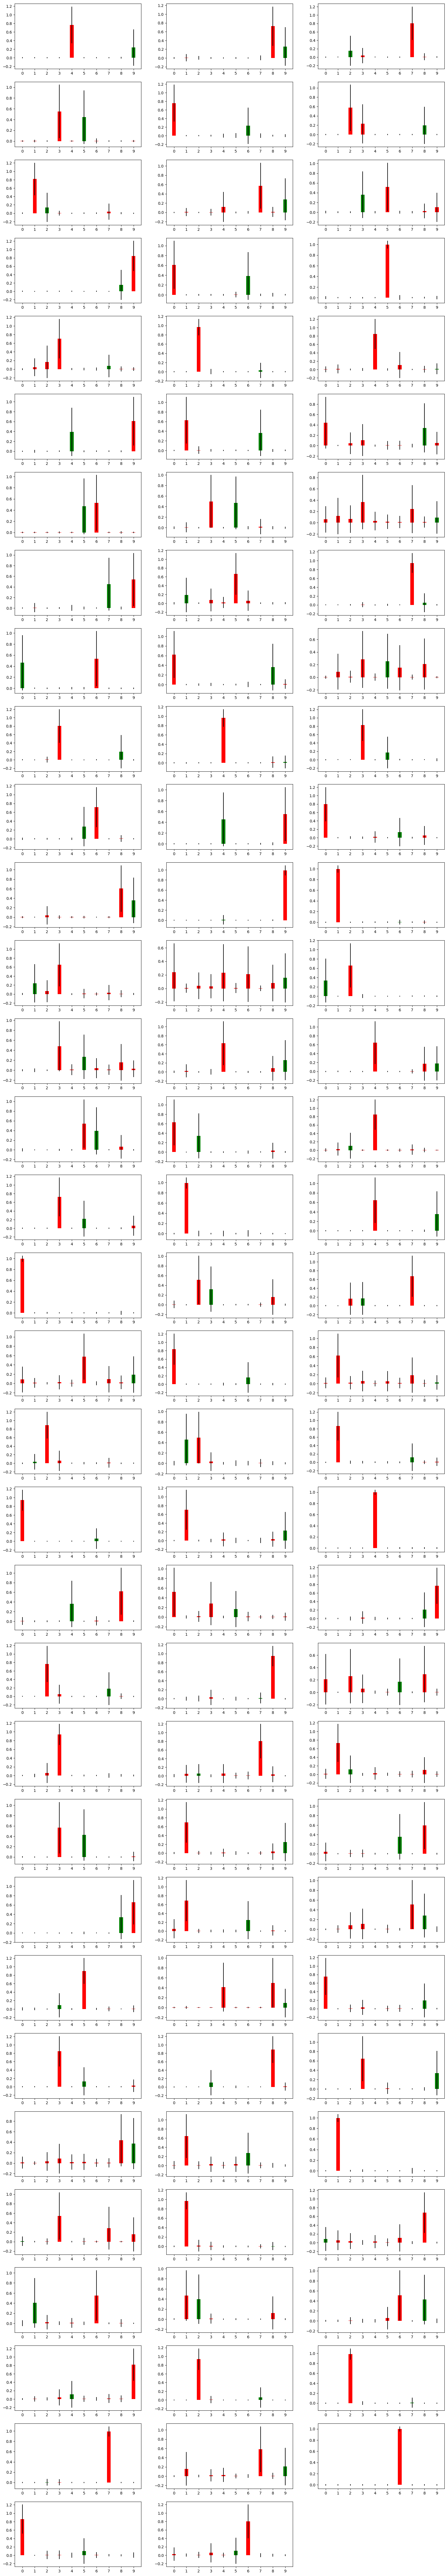

In [160]:
plot_instances(correct_classes[mask], mu[mask], var[mask])
plt.savefig('../results/figs/mnist/gp_misclassified.pdf')

In [124]:
def make_histogram(values, start=0.0, end=None, bins=10, plot=True, 
                   x_label=None, y_label=None, title=None, color=None,
                   width=None, density=False, cum=False, save=None,
                   legend=[], legend_loc="upper left"):
    if end is None:
        max_value = values.max()
    else:
        max_value = end
    if width is None:
        plotted = plt.hist(values, bins, range=(start, max_value), density=density, cumulative=cum, color=color)
    else:
        plotted = plt.hist(values, bins, range=(start, max_value), width=width, density=density, cumulative=cum, color=color)
    if plot:
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(legend, loc=legend_loc,
                   fontsize=8)
        
        if save:
            #use save as the path
            plt.savefig(save)

In [125]:
cnn_train_output = np.genfromtxt("../data/mnist_train_cnn_output.csv", delimiter=",")
cnn_test_output = np.genfromtxt("../data/mnist_test_cnn_output.csv", delimiter=",")

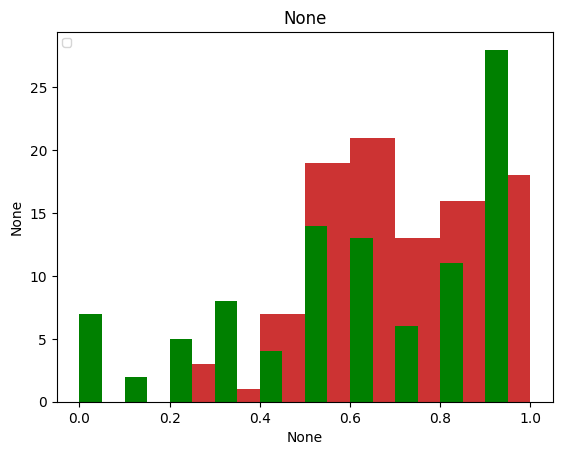

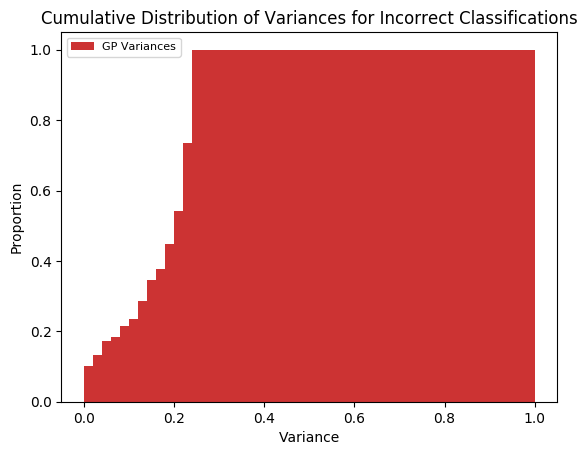

In [132]:
all_incorrect_mus = np.array([])
all_incorrect_vars = np.array([])

cnn_output = []

for cat in range(10):
    # get all examples that actually belong to this category
    cat_examples = correct_classes == cat
    # extract the subset of that digit that were incorrectly classified
    cat_incorrect_examples = cat_examples & mask 
    incorrectly_classified_mus = mu[cat_incorrect_examples]
    incorrectly_classified_vars = var[cat_incorrect_examples]
    
    corresponding_cnn_output = cnn_test_output[cat_incorrect_examples]
    
    # which ones were predicted (all incorrect)
    predicted_classes = np.argmax(mu[cat_incorrect_examples], axis=1)
    
    #print(predicted_classes)
    # extract the corresponding values into an array
    incorrect_prediction_mus, incorrect_prediction_vars = [], []
    for (i, c) in enumerate(predicted_classes):
        incorrect_prediction_mus.append(incorrectly_classified_mus[i, c])
        incorrect_prediction_vars.append(incorrectly_classified_vars[i, c])
        
        cnn_output.append(corresponding_cnn_output[i, c])

    incorrect_prediction_mus = np.array(incorrect_prediction_mus)
    incorrect_prediction_vars = np.array(incorrect_prediction_vars)

    
    all_incorrect_mus = np.append(all_incorrect_mus, incorrect_prediction_mus)
    all_incorrect_vars = np.append(all_incorrect_vars, incorrect_prediction_vars)
    
#     incorrect_mus = mu[cat_incorrect_examples, cat]
#     incorrect_vars = var[cat_incorrect_examples,cat]
#     all_incorrect_mus = np.append(all_incorrect_mus, incorrect_mus)
#     all_incorrect_vars = np.append(all_incorrect_vars, incorrect_vars)
#     make_histogram(incorrect_vars)
    #make_histogram(incorrect_mus)
cnn_output = np.array(cnn_output)
#print(cnn_output)
#print(all_incorrect_mus)
#print(all_incorrect_vars)


make_histogram(all_incorrect_mus, end = 1.0, plot=False, width=0.1, 
               color=[0.8, 0.2, 0.2],)
make_histogram(cnn_output, end = 1.0, plot=True, color='g', width=0.05)
plt.show()

make_histogram(all_incorrect_vars, 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend=["GP Variances"],
               legend_loc="upper left",
               title="Cumulative Distribution of Variances for Incorrect Classifications",
               save='../results/figs/mnist/incorrect_variances_Matern12.pdf')


[ 0.90331048  0.59369749  0.50962085  0.89131516  0.57220274  0.55512321
  0.96917677  0.01412501  0.98712838  0.86262989  0.8931365   0.32015684
  0.55975604  0.69733238  0.89649504  0.47877976  0.01403255  0.96951306
  0.02012727  0.67756796  0.40853724  0.98490661  0.92028916  0.58195996
  0.64834028  0.99035245  0.68117052  0.76685452  0.80956078  0.30286437
  0.74878436  0.10937572  0.98942167  0.55372435  0.53163242  0.98581785
  0.60648233  0.81093949  0.98190707  0.99998498  0.85221952  0.97004414
  0.69256592  0.33269933  0.99922466  0.96774095  0.94874835  0.41368446
  0.99184084  0.66895992  0.76194686  0.99985576  0.60452378  0.4777588
  0.12072045  0.05180589  0.58093953  0.97830862  0.33529165  0.71866906
  0.30877954  0.97971183  0.96523017  0.84908968  0.98028183  0.99594337
  0.65477395  0.75955886  0.31098488  0.9946906   0.35272592  0.90525806
  0.99963975  0.61641431  0.22687411  0.63674641  0.68270165  0.29880241
  0.51349282  0.77319634  0.57426888  0.21741168  0.

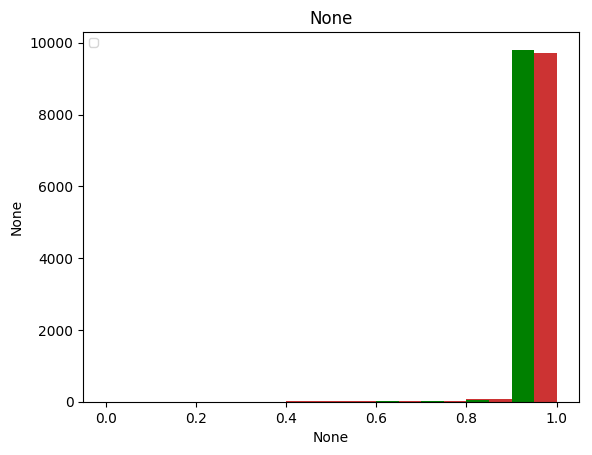

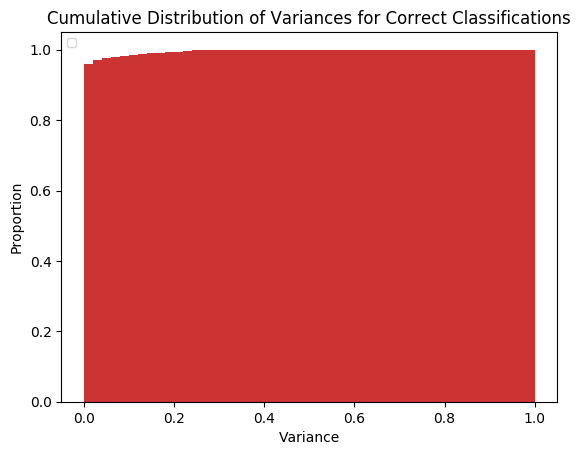

In [131]:
all_correct_mus = np.array([])
all_correct_vars = np.array([])

cnn_output_correct = []

for cat in range(10):
    # get all examples that actually belong to this category
    cat_examples = correct_classes == cat
    # extract the subset of that digit that were incorrectly classified
    cat_correct_examples = cat_examples & ~mask 
    correctly_classified_mus = mu[cat_correct_examples]
    correctly_classified_vars = var[cat_correct_examples]
    
    corresponding_cnn_output = cnn_test_output[cat_correct_examples]
    
    # which ones were predicted (all incorrect)
    predicted_classes = np.argmax(mu[cat_correct_examples], axis=1)
    
    #print(predicted_classes)
    # extract the corresponding values into an array
    correct_prediction_mus, correct_prediction_vars = [], []
    for (i, c) in enumerate(predicted_classes):
        correct_prediction_mus.append(correctly_classified_mus[i, c])
        correct_prediction_vars.append(correctly_classified_vars[i, c])
        
        cnn_output_correct.append(corresponding_cnn_output[i, c])

    correct_prediction_mus = np.array(correct_prediction_mus)
    correct_prediction_vars = np.array(correct_prediction_vars)

    
    all_correct_mus = np.append(all_correct_mus, correct_prediction_mus)
    all_correct_vars = np.append(all_correct_vars, correct_prediction_vars)
    
#     incorrect_mus = mu[cat_incorrect_examples, cat]
#     incorrect_vars = var[cat_incorrect_examples,cat]
#     all_incorrect_mus = np.append(all_incorrect_mus, incorrect_mus)
#     all_incorrect_vars = np.append(all_incorrect_vars, incorrect_vars)
#     make_histogram(incorrect_vars)
    #make_histogram(incorrect_mus)
cnn_output_correct = np.array(cnn_output_correct)
print(cnn_output)
print(all_correct_mus)
print(all_correct_vars)

make_histogram(all_correct_mus, end = 1.0, plot=False, width=0.1,
               color=[0.8, 0.2, 0.2],)
make_histogram(cnn_output_correct, end = 1.0, plot=True, color='g', width=0.05)
plt.show()

make_histogram(all_correct_vars, 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               title="Cumulative Distribution of Variances for Correct Classifications",
               save='../results/figs/mnist/correct_variances_Matern12.pdf')


In [15]:
mus_vars_correct = np.array(list(zip(all_correct_mus, all_correct_vars)))

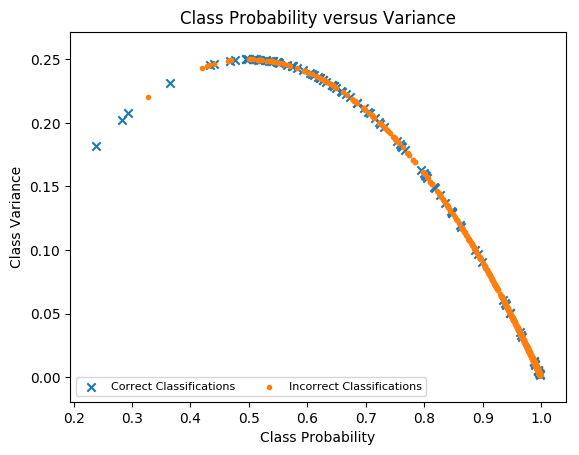

In [133]:
cor_scatter = plt.scatter(all_incorrect_mus, all_incorrect_vars, label="Incorrect", marker='x')
incorr_scatter = plt.scatter(all_correct_mus, all_correct_vars, label="Correct",  marker='.')
plt.xlabel("Class Probability")
plt.ylabel("Class Variance")
plt.title("Class Probability versus Variance")
plt.legend((cor_scatter, incorr_scatter),
           ('Correct Classifications', 'Incorrect Classifications'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.savefig('../results/figs/mnist/mu_versus_var.pdf')

GP: mean incorrect prediction prob =  0.705100916107
GP: stddev incorrect prediction prob =  0.184176251224
GP: median incorrect prediction prob =  0.685372573242
CNN: mean incorrect prediction prob =  0.752902235543
CNN: stddev incorrect prediction prob =  0.184316559188
CNN: media incorrect prediction prob =  0.74878436327


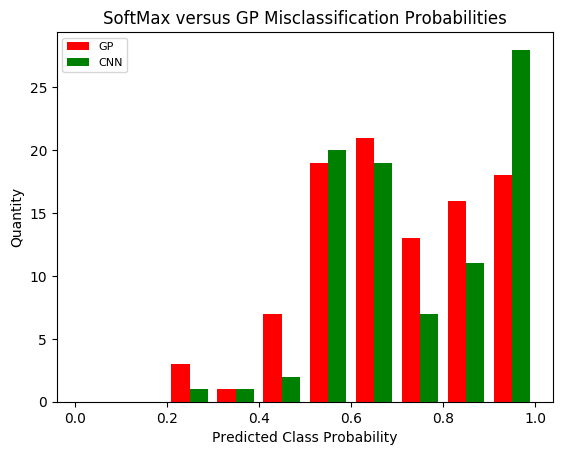

In [134]:
# Explore the failure of the Neural Net softmax layer
cnn_predicted_classes = np.argmax(cnn_test_output, axis=1)
cnn_incorrect_predictions = cnn_predicted_classes != correct_classes

cnn_incorrect_probs = cnn_test_output[cnn_incorrect_predictions]
cnn_incorrect_true_classes = correct_classes[cnn_incorrect_predictions]
cnn_bad_predictions = np.max(cnn_incorrect_probs, axis=1)



#make_histogram(all_incorrect_mus, end = 1.0, plot=False, width=0.1)
#make_histogram(cnn_bad_predictions, color='g', width=0.05)

make_histogram([all_incorrect_mus, cnn_bad_predictions], end=1.0, color=['r', 'g'], width=0.04,
               x_label="Predicted Class Probability",
               y_label="Quantity",
               legend=("GP", "CNN"),
               legend_loc="upper left",
               title="SoftMax versus GP Misclassification Probabilities",
               save='../results/figs/mnist/cnn_vs_gp_misclassification_prob_matern12.pdf',
               )

print("GP: mean incorrect prediction prob = ", np.mean(all_incorrect_mus))
print("GP: stddev incorrect prediction prob = ", np.sqrt(np.var(all_incorrect_mus)))
print("GP: median incorrect prediction prob = ", np.median(all_incorrect_mus))

print("CNN: mean incorrect prediction prob = ", np.mean(cnn_bad_predictions))
print("CNN: stddev incorrect prediction prob = ", np.sqrt(np.var(cnn_bad_predictions)))
print("CNN: media incorrect prediction prob = ", np.median(cnn_bad_predictions))


In [19]:
plt.savefig('../results/figs/mnist/incorrect_predictions_mu.pdf')

In [101]:
# Question: can we combine results from CNN _and_ GP to improve classification results?

# for each example, get both GP and CNN class predictions and prob
indices = np.argmax(mu, axis=1)
gp_predictions = []
for (i, index) in enumerate(indices):
    gp_predictions.append([index, mu[i, index]])

indices = np.argmax(cnn_test_output, axis=1)
cnn_predictions = []
for (i, index) in enumerate(indices):
    cnn_predictions.append([index, cnn_test_output[i, index]])

decision = []
for ((gp_class, gp_prob), (cnn_class, cnn_prob)) in zip(gp_predictions, cnn_predictions):
    if gp_prob >= cnn_prob:
        decision.append([0, gp_class, gp_prob]) # tag with GP source
    else:
        decision.append([1, cnn_class, cnn_prob]) # tag with CNN source
decision = np.array(decision)

In [102]:
sources = decision[:, 0]
print("GP decisions: " , np.count_nonzero(sources == 0))
print("CNN decisions: ", np.count_nonzero(sources == 1))

GP decisions:  199
CNN decisions:  9801


In [103]:
combined_decisions = decision[:, 1]
combined_incorrect = combined_decisions != correct_classes
print("Combined incorrect: ", np.count_nonzero(combined_incorrect))
print(np.nonzero(combined_incorrect))

print("GP-only incorrect: ", np.count_nonzero(mask))
print(np.nonzero(mask))

print("CNN-only incorrect: ", np.count_nonzero(cnn_incorrect_predictions))
print(np.nonzero(cnn_incorrect_predictions))


print("Overlap misclassified Combined vs CNN: ", np.count_nonzero(cnn_incorrect_predictions & combined_incorrect))
print(np.nonzero(cnn_incorrect_predictions & combined_incorrect))

print("Overlap misclassified Combined vs GP: ", np.count_nonzero(mask & combined_incorrect))
print(np.nonzero(mask & combined_incorrect))
print("Overlap misclassified CNN vs GP: ", np.count_nonzero(mask & cnn_incorrect_predictions))
disagreement = mask & cnn_incorrect_predictions # where one model predicts correctly and the other not
                                                 # these might be salvageable with ensemble
both_incorrect = mask & cnn_incorrect_predictions  # these are the hardest ones, fool both models

print(np.where(disagreement))


Combined incorrect:  87
(array([  92,  320,  321,  340,  445,  582,  659,  720,  882,  947, 1014,
       1039, 1226, 1232, 1242, 1247, 1393, 1414, 1522, 1527, 1530, 1621,
       1878, 1901, 2035, 2040, 2053, 2070, 2118, 2129, 2130, 2135, 2182,
       2293, 2329, 2369, 2406, 2414, 2462, 2488, 2597, 2654, 2760, 2896,
       2921, 2927, 2939, 3030, 3060, 3073, 3225, 3422, 3503, 3520, 3534,
       3558, 3727, 3767, 3808, 3853, 3906, 4176, 4248, 4360, 4571, 4731,
       4740, 4761, 4807, 5937, 5955, 6166, 6173, 6576, 6597, 6625, 6651,
       6783, 8408, 8527, 9009, 9015, 9664, 9692, 9729, 9770, 9982]),)
GP-only incorrect:  98
(array([  92,  320,  321,  340,  445,  582,  659,  882,  938,  947,  965,
       1014, 1039, 1226, 1232, 1242, 1260, 1319, 1378, 1393, 1414, 1522,
       1527, 1530, 1621, 1717, 1737, 1878, 1901, 2035, 2040, 2053, 2118,
       2129, 2130, 2135, 2182, 2293, 2329, 2369, 2406, 2414, 2454, 2462,
       2488, 2597, 2654, 2760, 2896, 2921, 2927, 2939, 3030, 3060, 3073,
     

(77,)


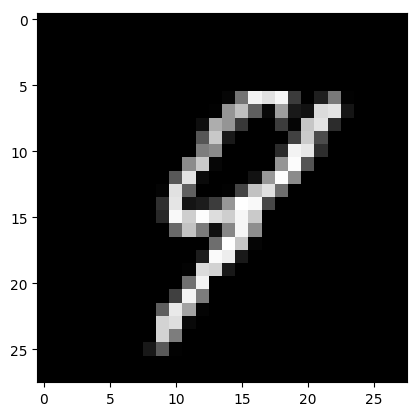

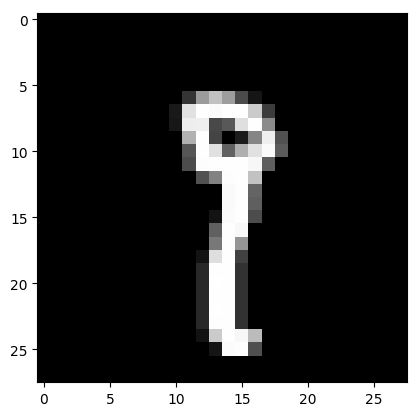

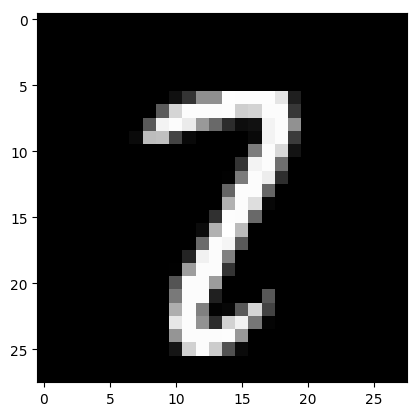

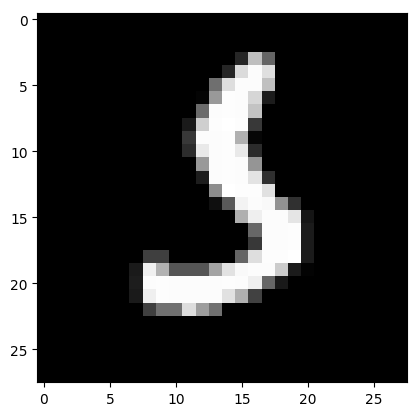

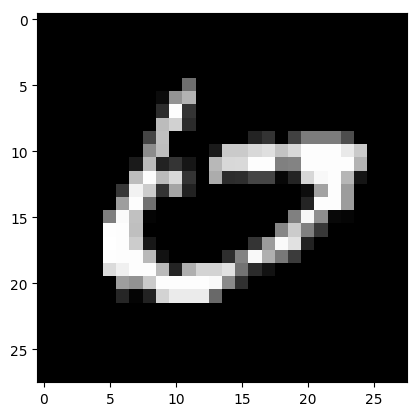

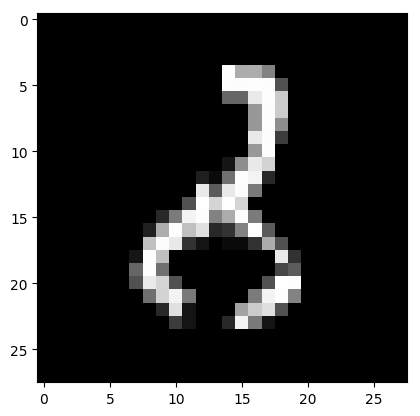

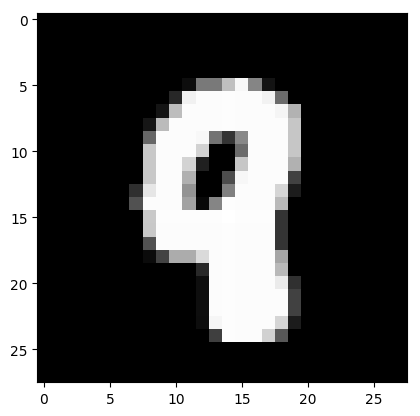

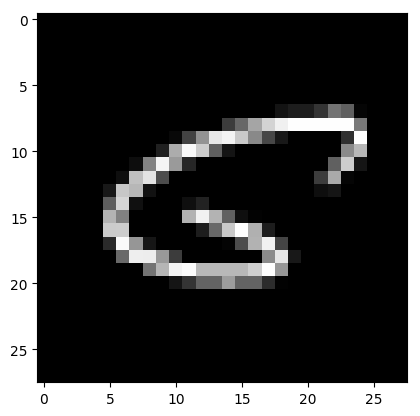

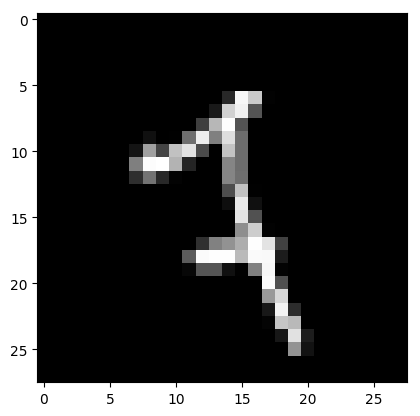

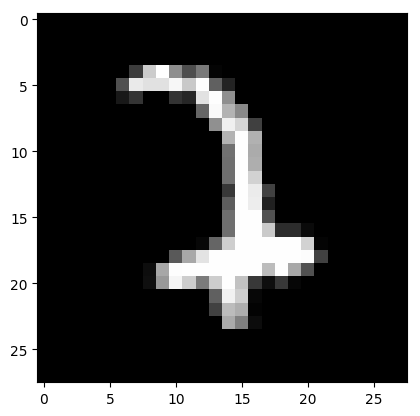

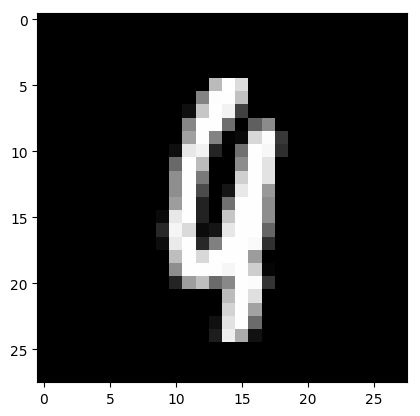

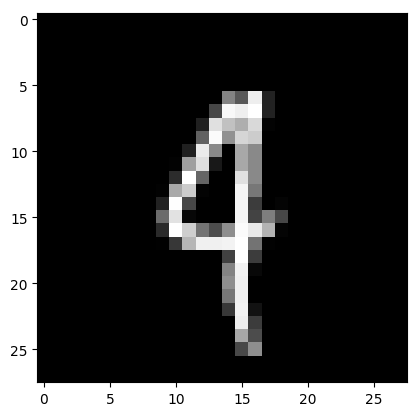

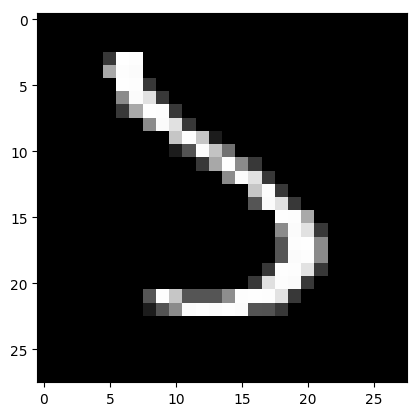

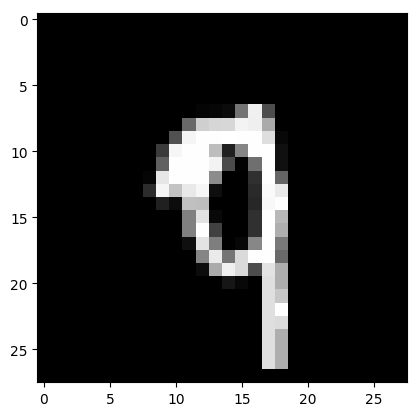

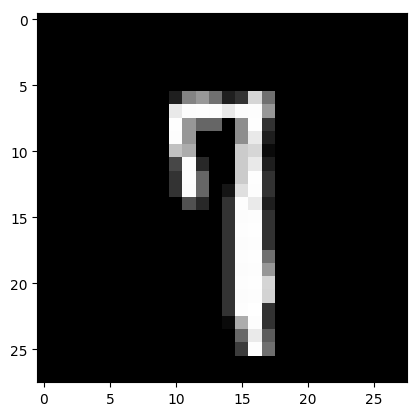

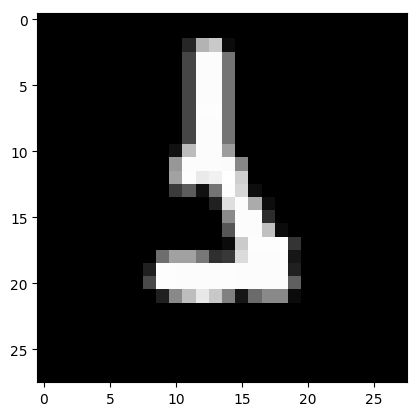

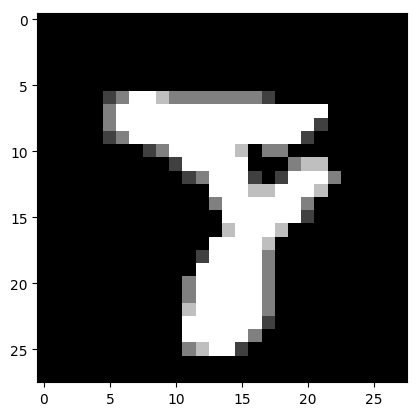

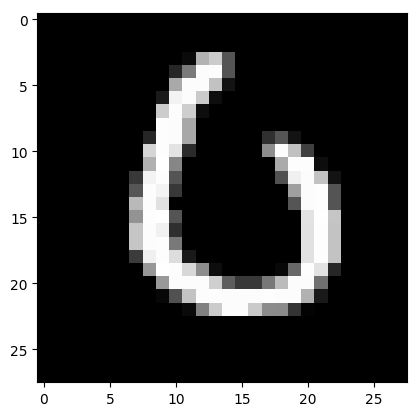

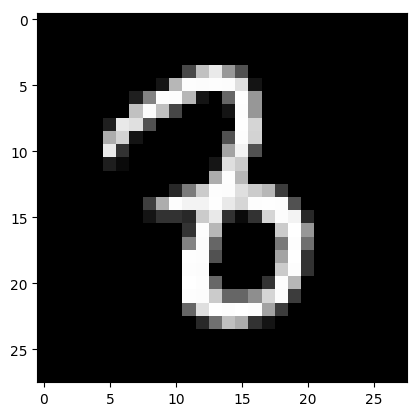

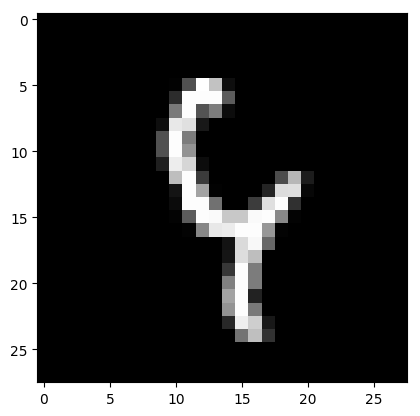

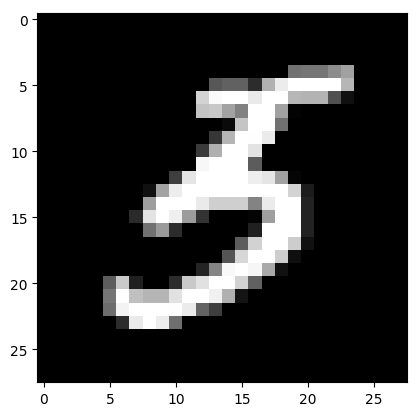

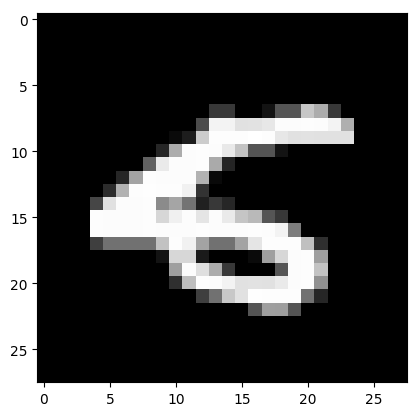

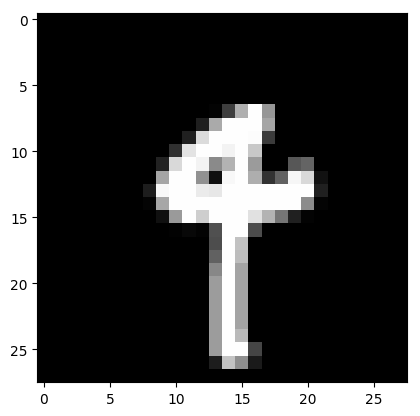

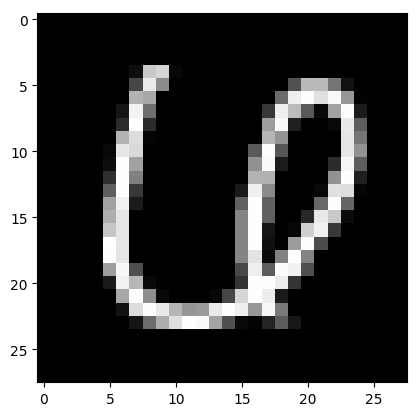

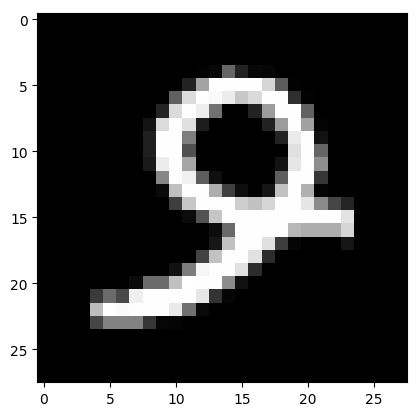

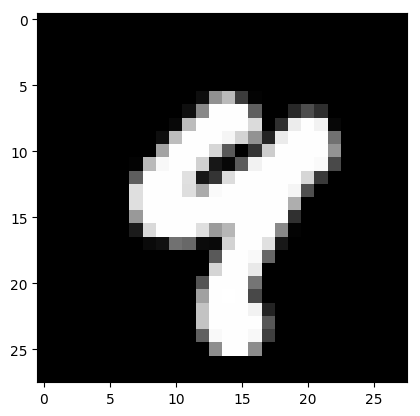

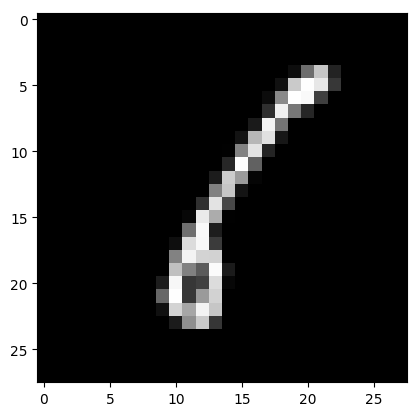

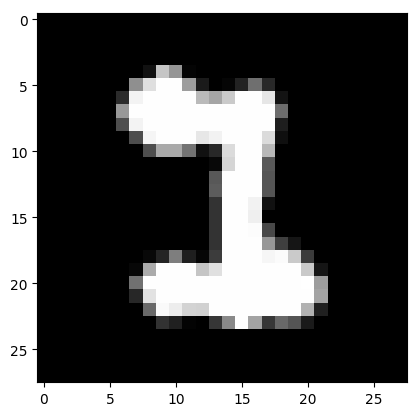

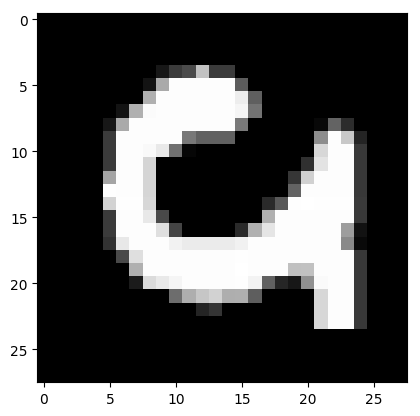

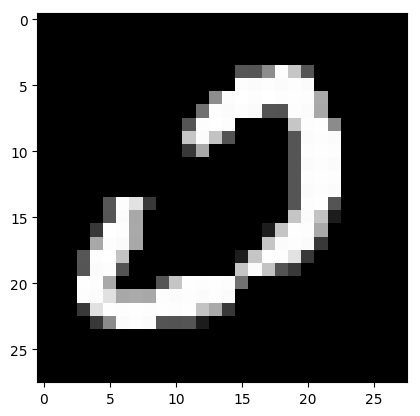

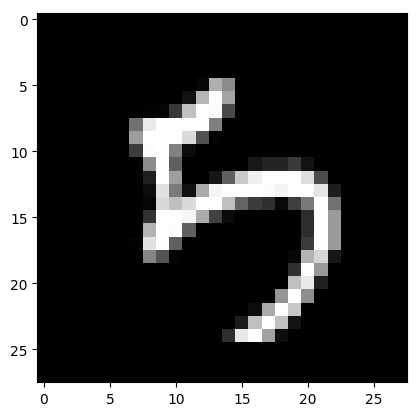

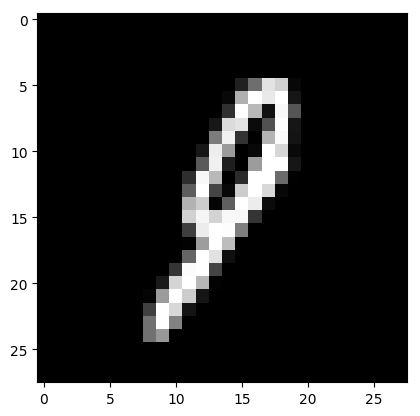

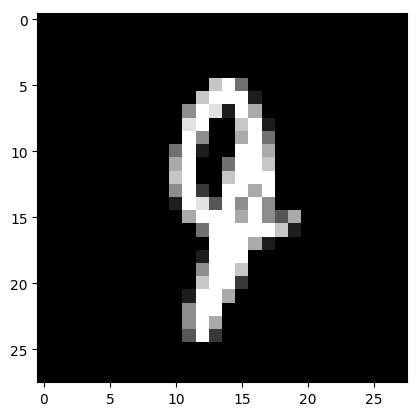

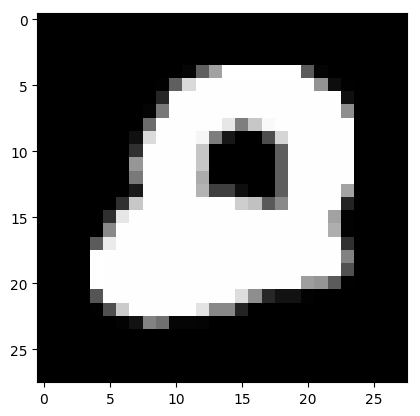

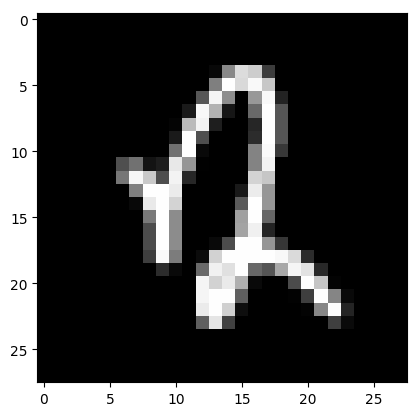

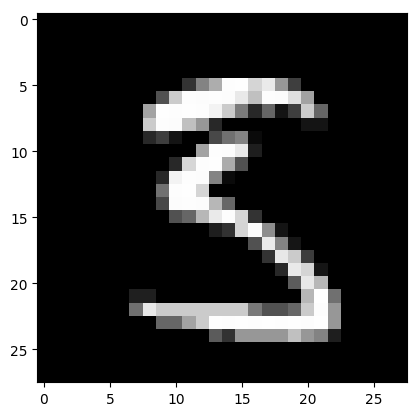

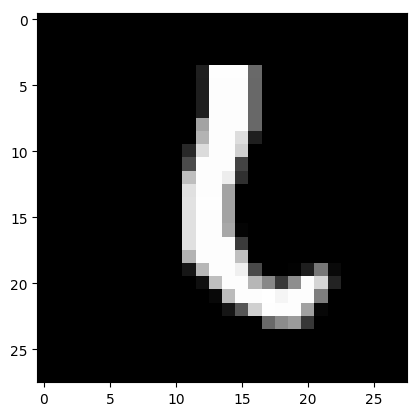

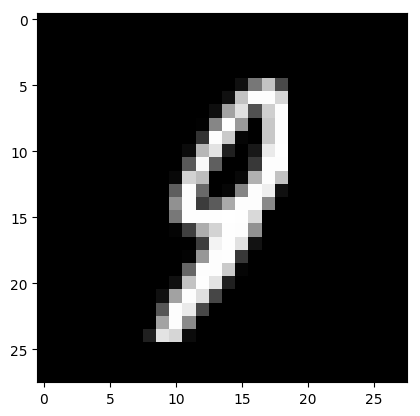

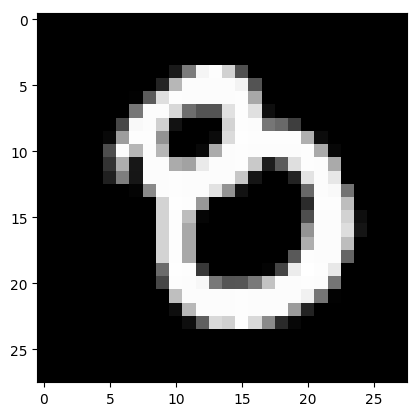

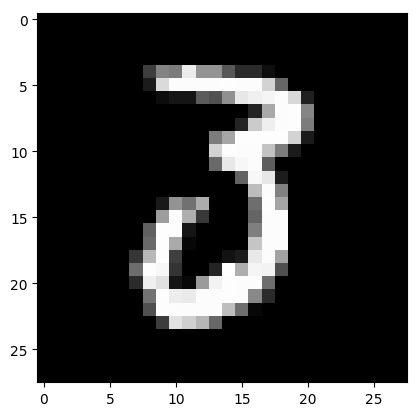

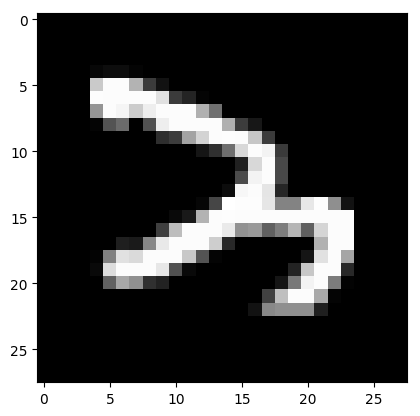

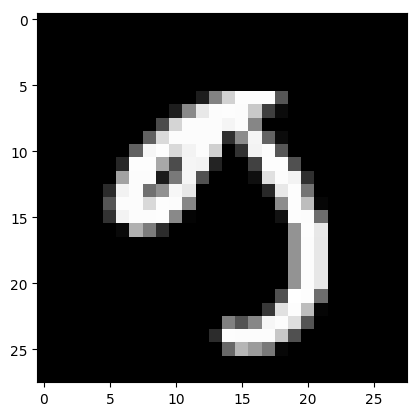

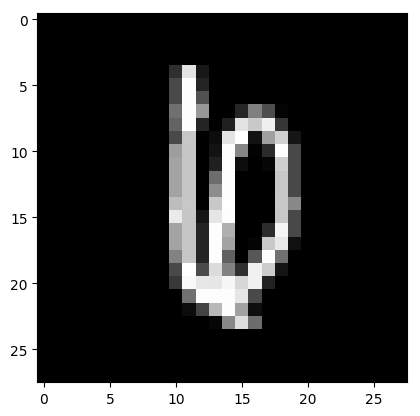

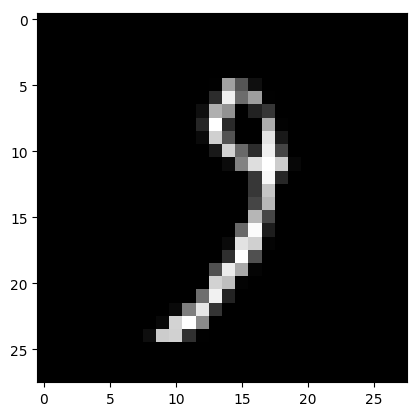

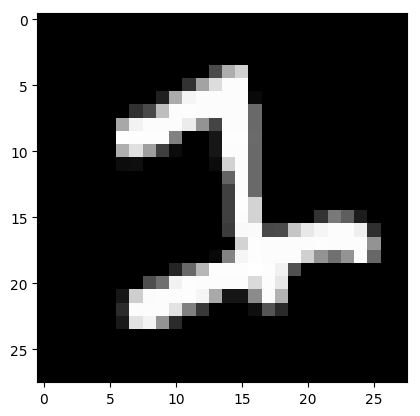

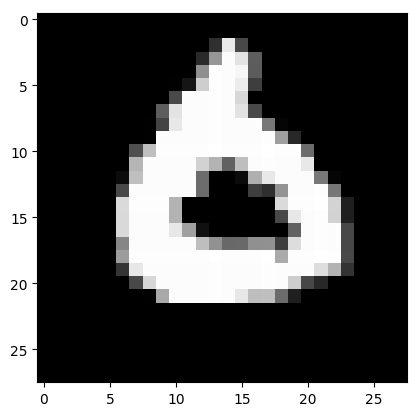

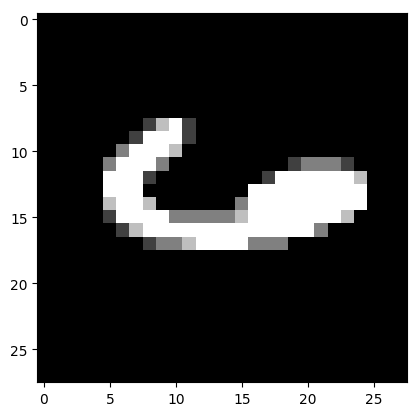

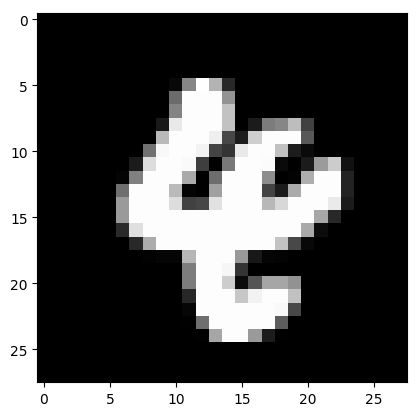

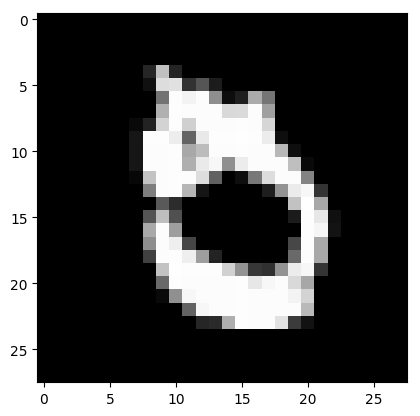

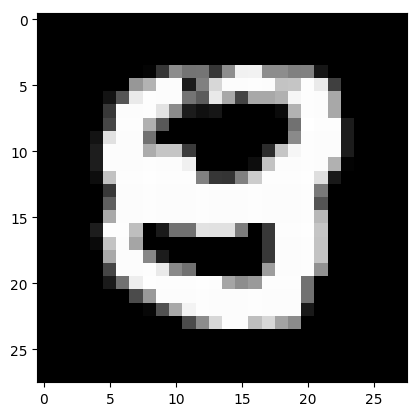

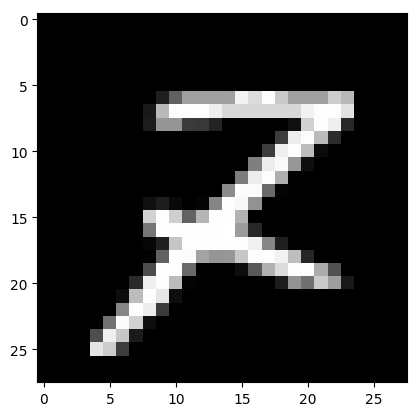

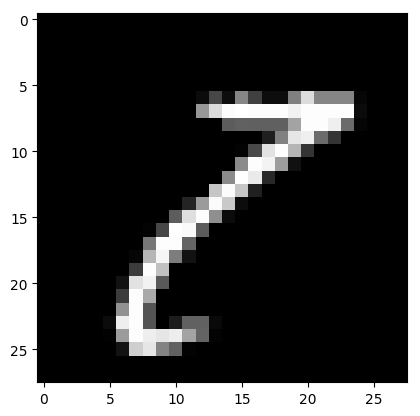

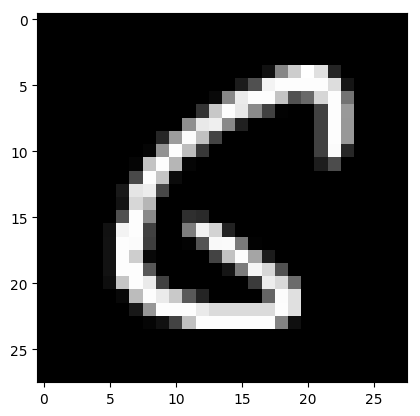

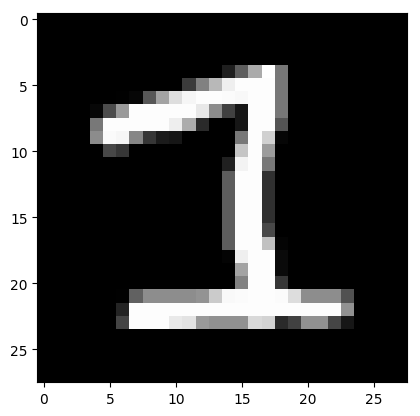

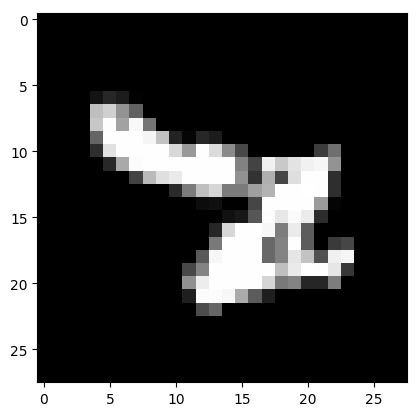

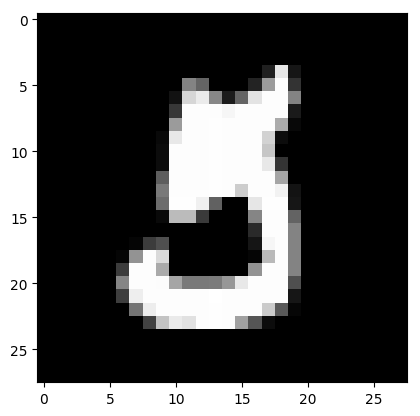

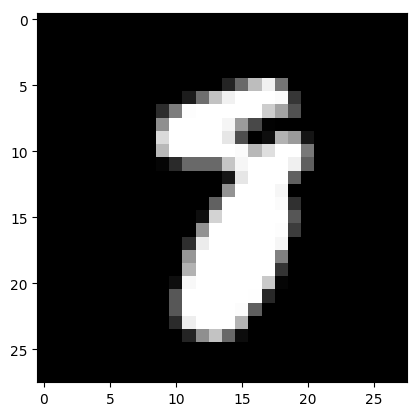

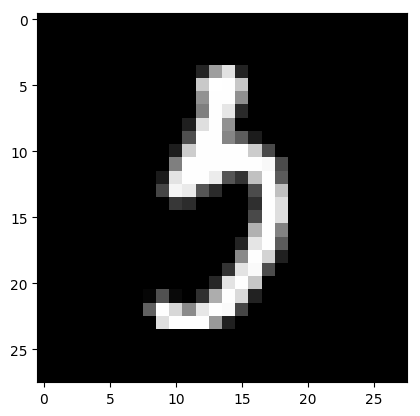

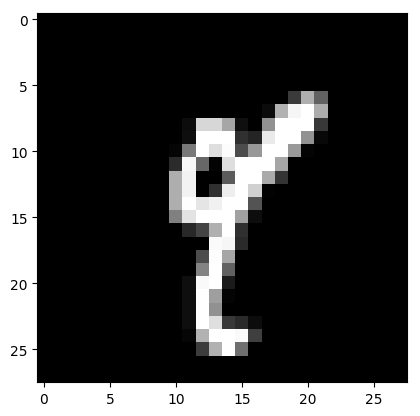

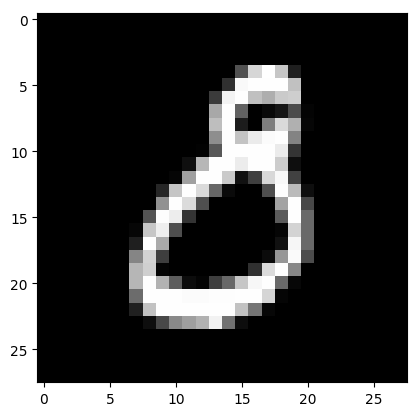

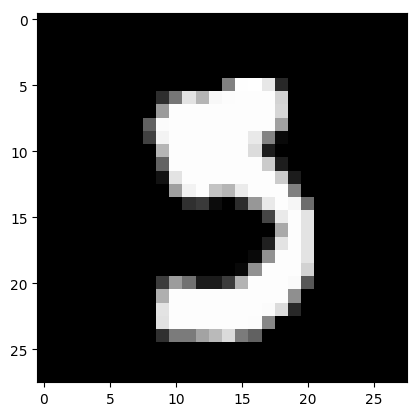

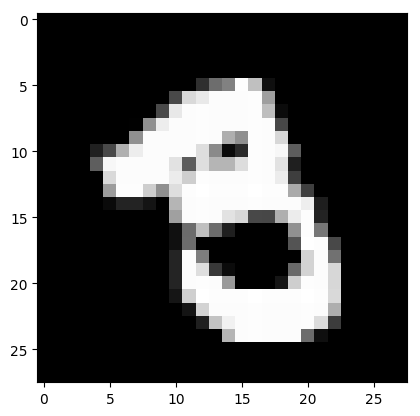

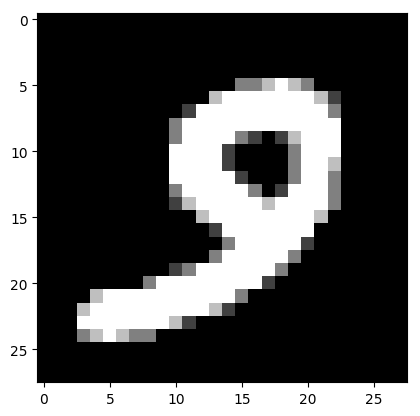

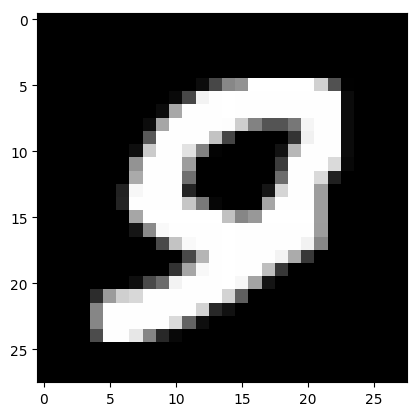

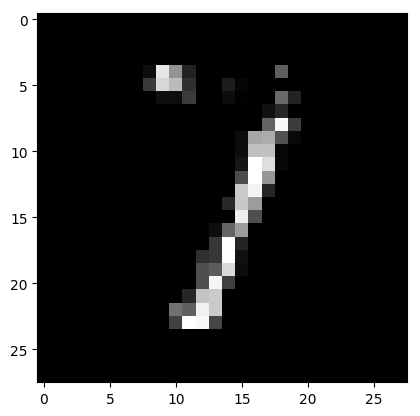

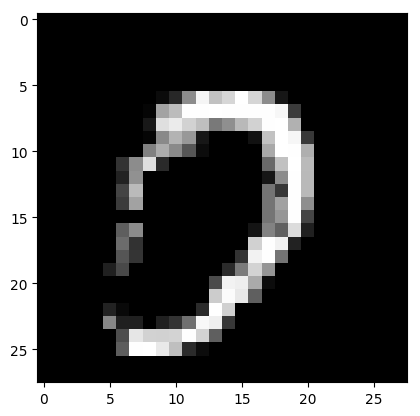

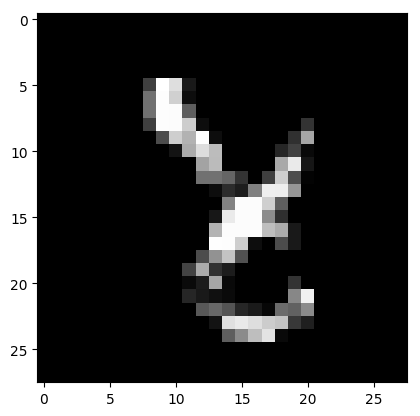

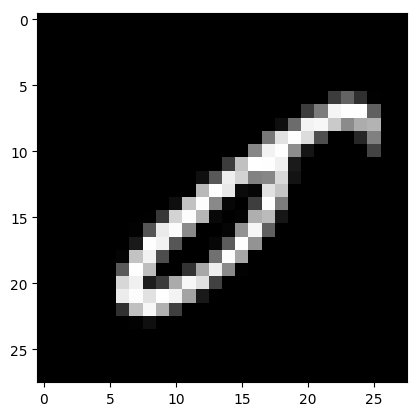

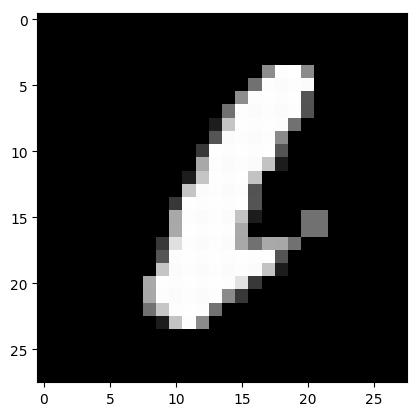

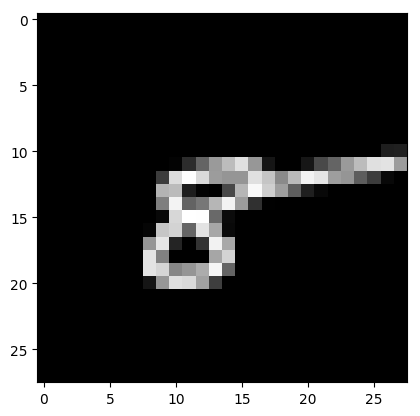

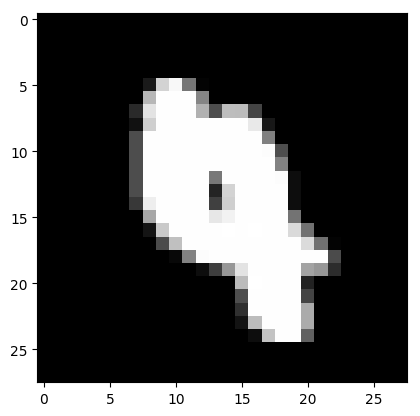

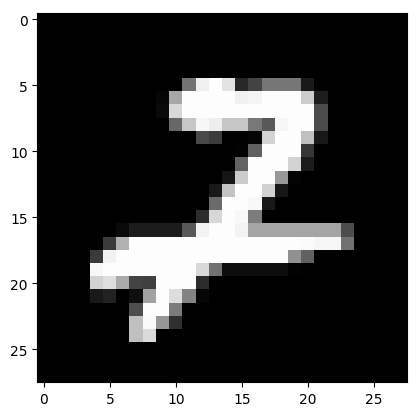

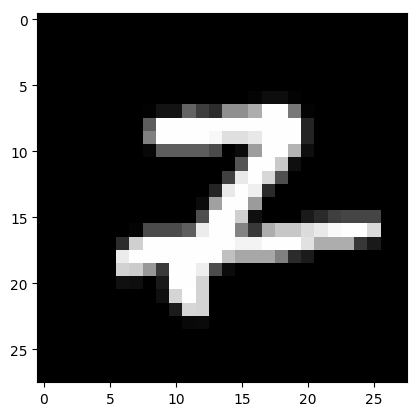

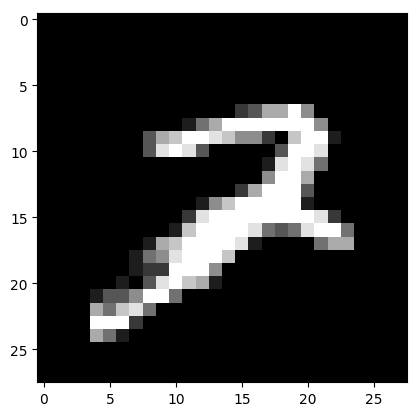

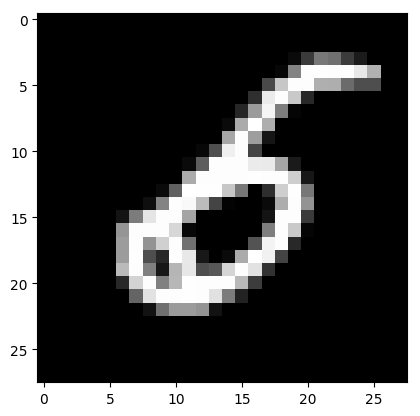

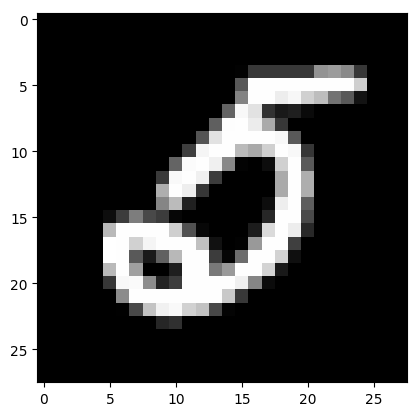

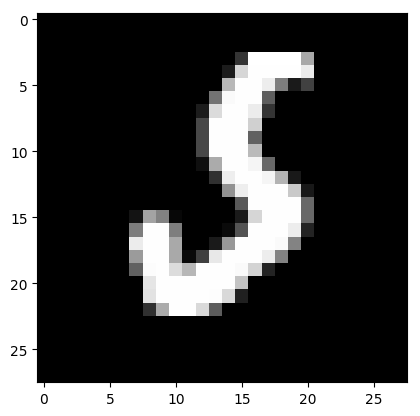

In [116]:
disagreement_indices = np.nonzero(disagreement)[0]    
print(disagreement_indices.shape)
for index in disagreement_indices:  
    plt.imshow(mnist_test_full[index], cmap=plt.get_cmap('gray'))
    plt.show()

In [108]:
# # Of the ones that were disagreed upon, how many were correctly determined by GP versus CNN
# # `disagreement` contains a mask of values each predicted differently

# disagreed_gp_predictions = predicted_classes[disagreement]
# disagreed_gp_predictions_correct = disagreed_gp_predictions == correct_classes[disagreement]
# disagreed_gp_predictions_correct_count = np.count_nonzero(disagreed_gp_predictions_correct)

# disagreed_cnn_predictions = cnn_predicted_classes[disagreement_indices]
# disagreed_cnn_predictions_correct = disagreed_cnn_predictions == correct_classes[disagreement]
# disagreed_cnn_predictions_correct_count = np.count_nonzero(disagreed_cnn_predictions_correct)

# print(mu[disagreement])

# print(disagreed_gp_predictions_correct_count)
# print(disagreed_cnn_predictions_correct_count)


(77,)


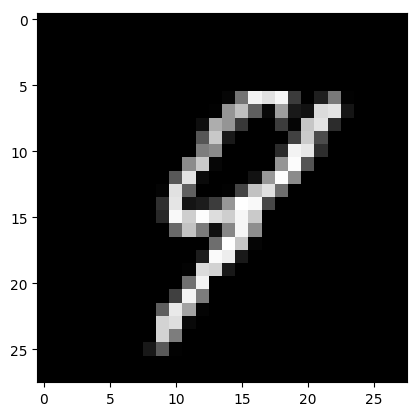

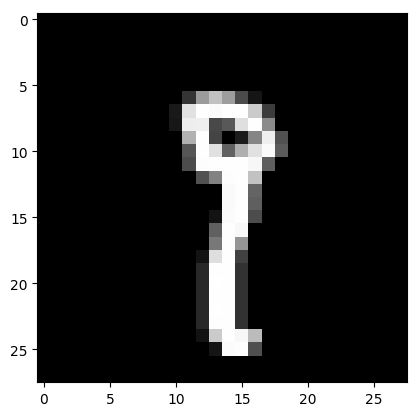

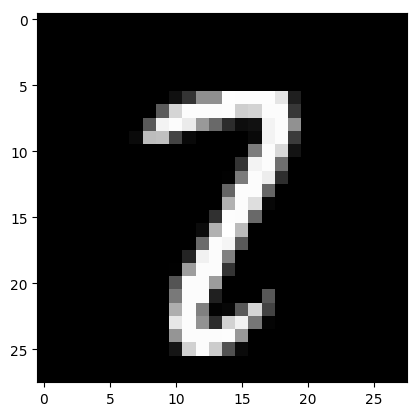

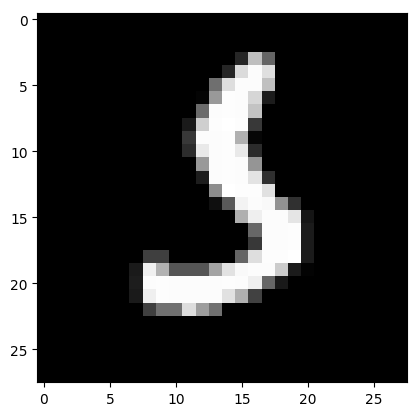

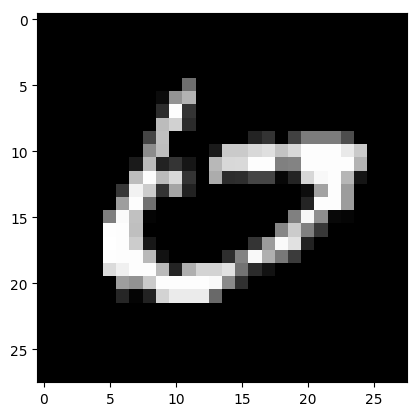

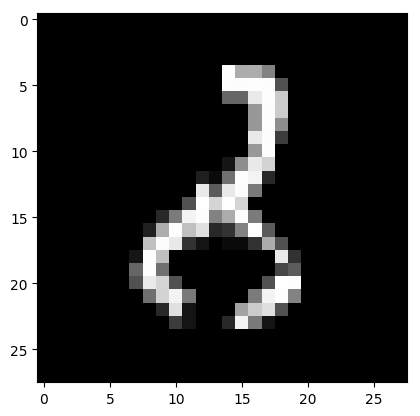

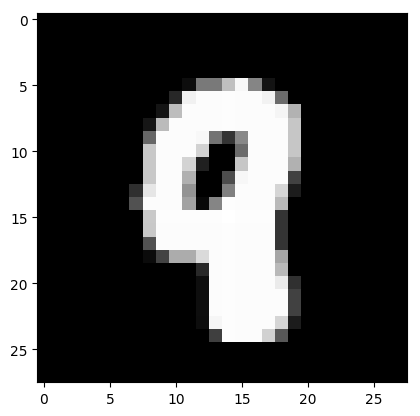

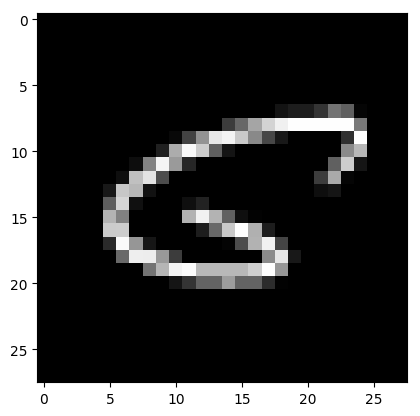

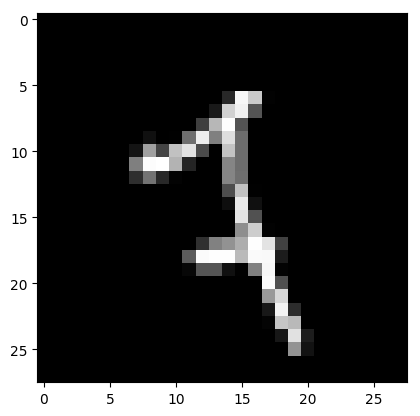

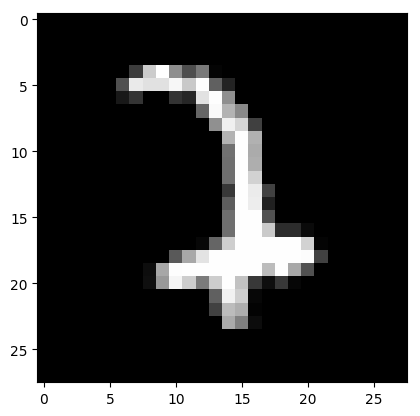

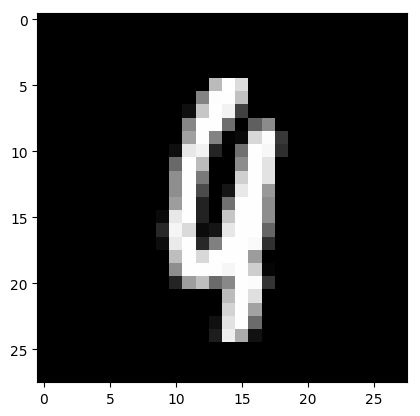

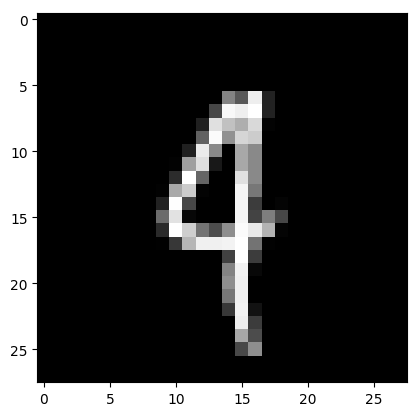

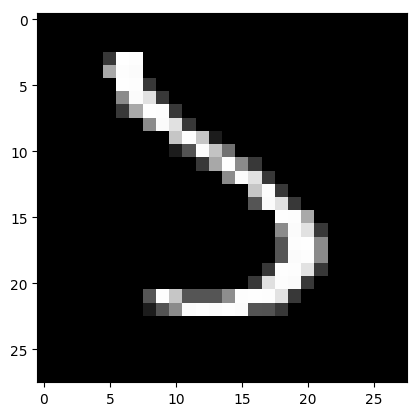

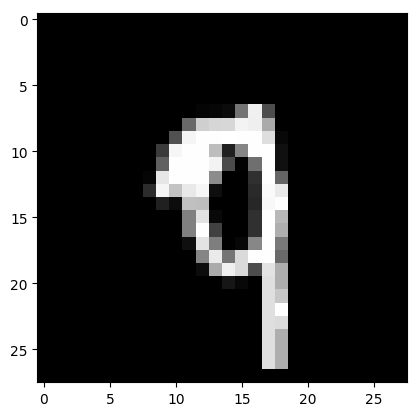

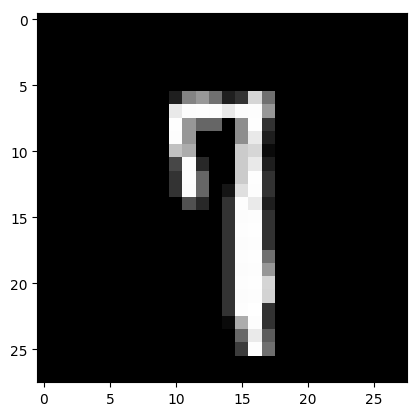

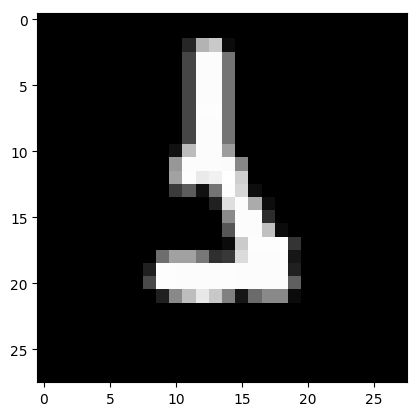

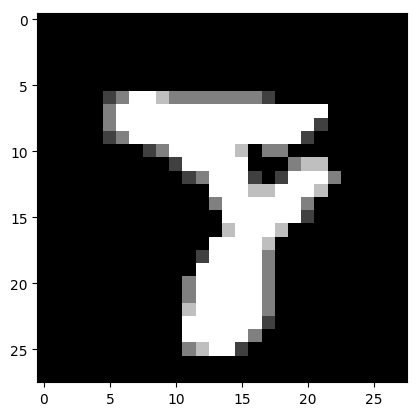

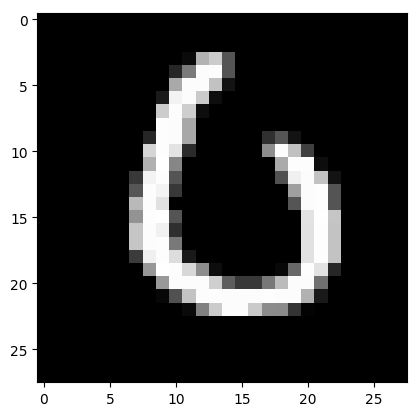

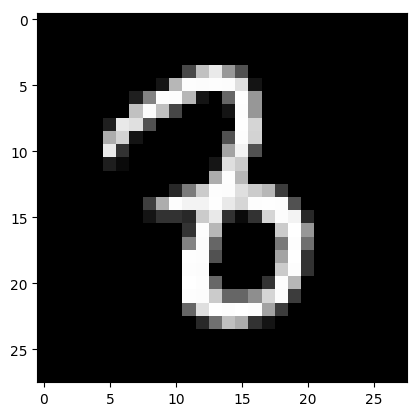

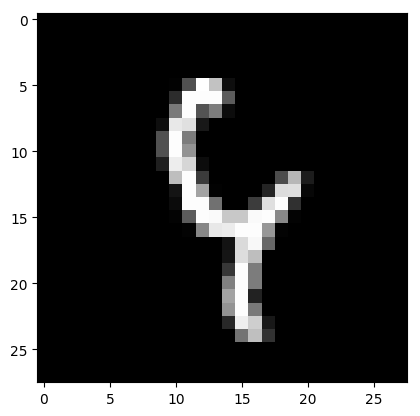

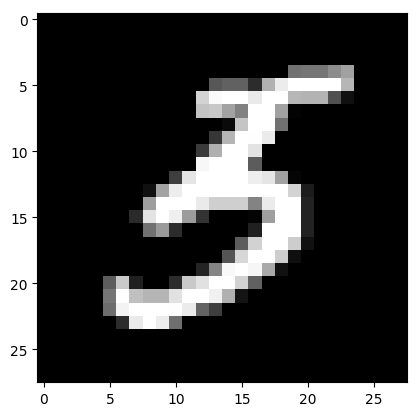

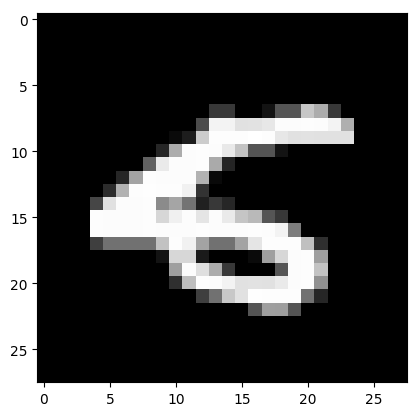

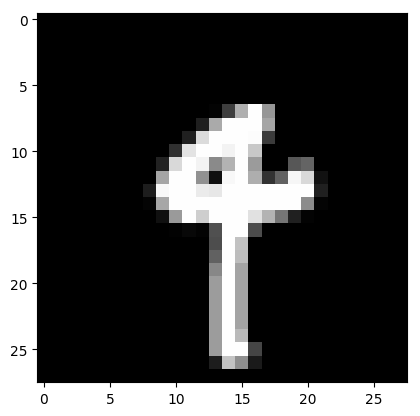

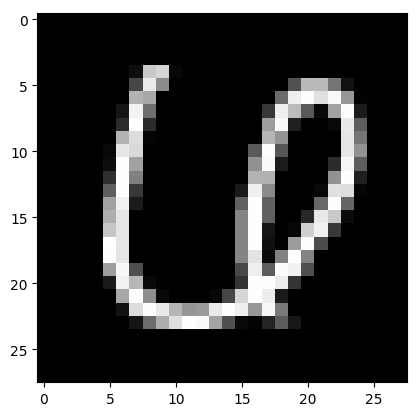

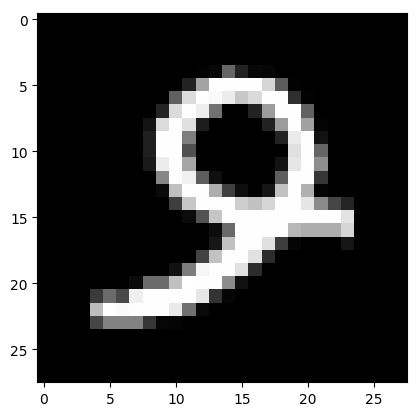

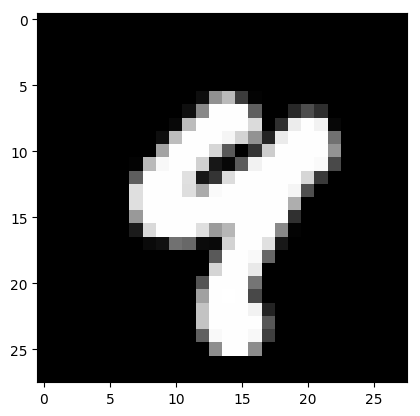

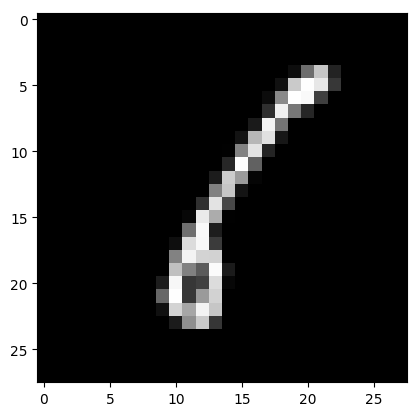

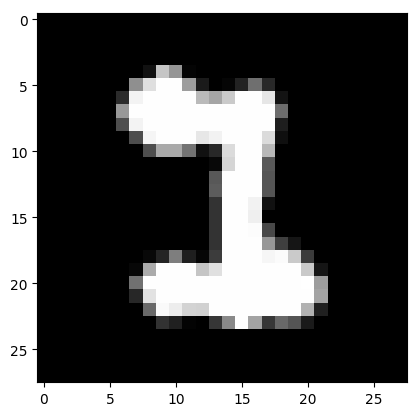

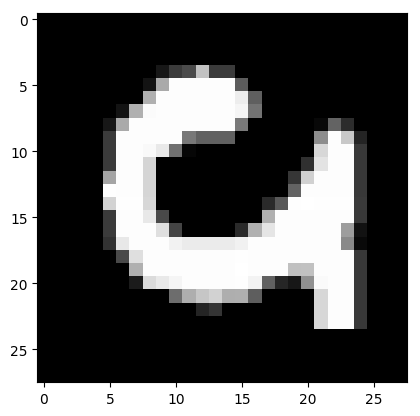

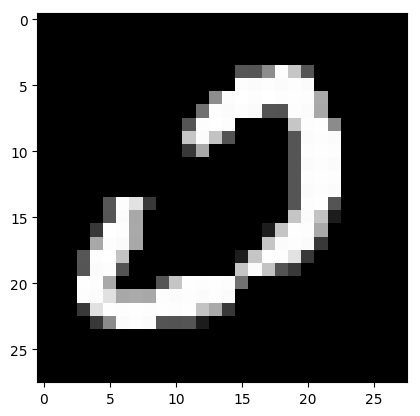

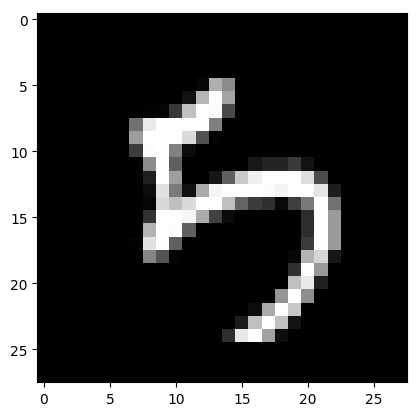

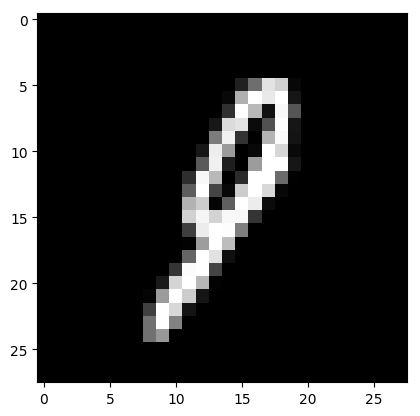

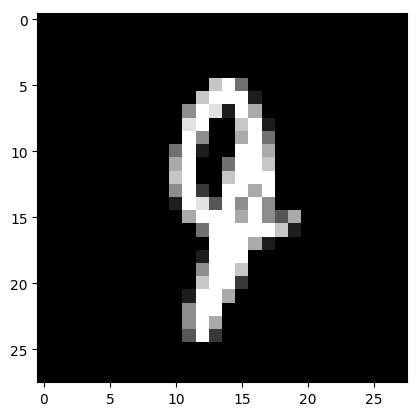

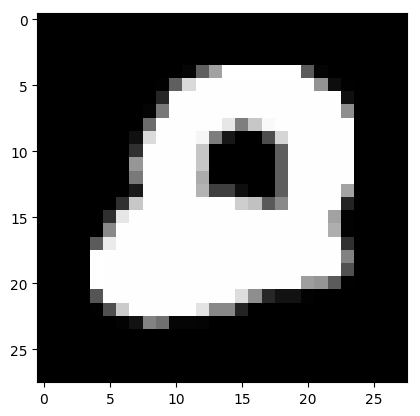

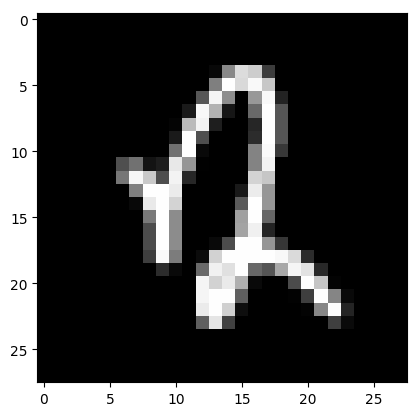

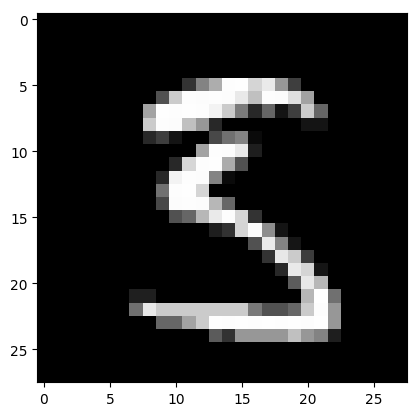

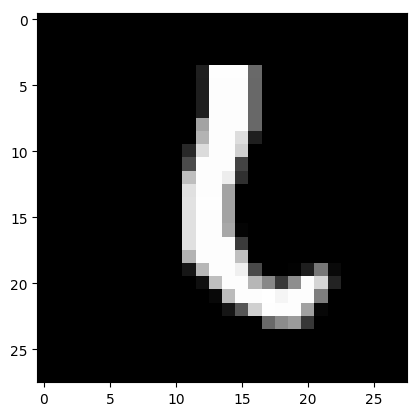

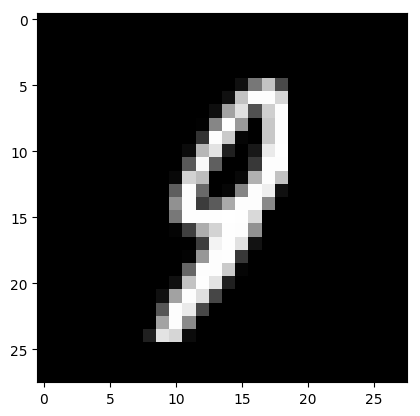

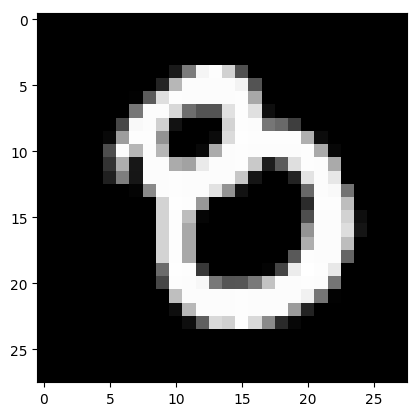

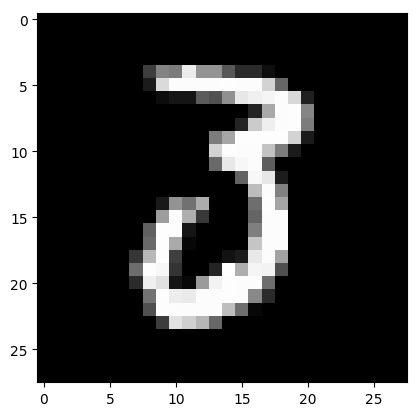

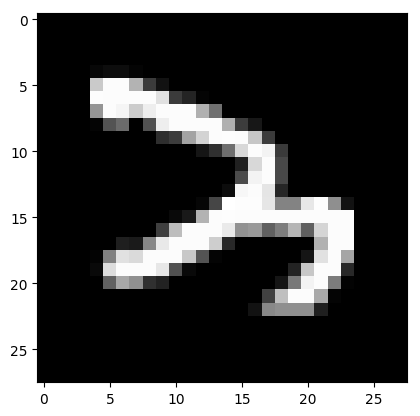

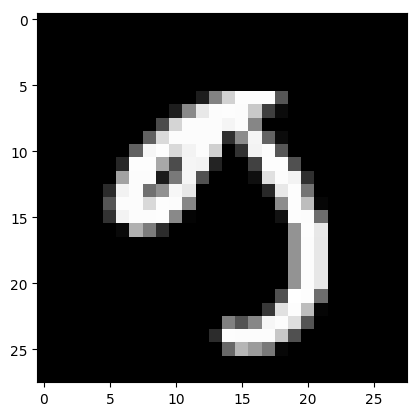

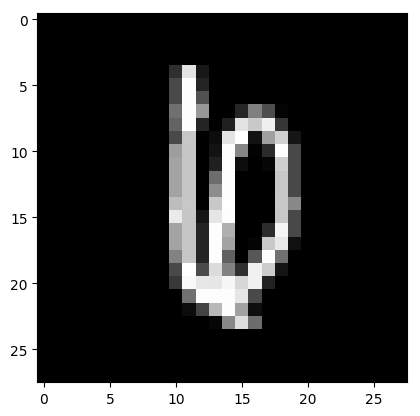

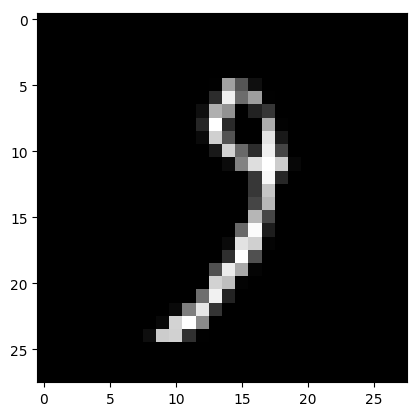

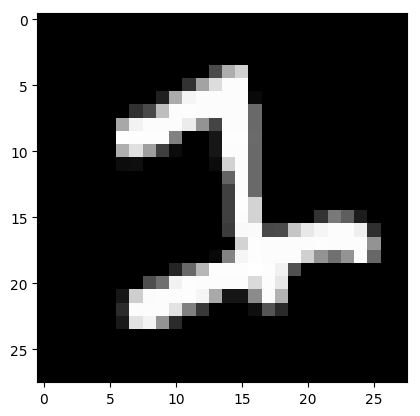

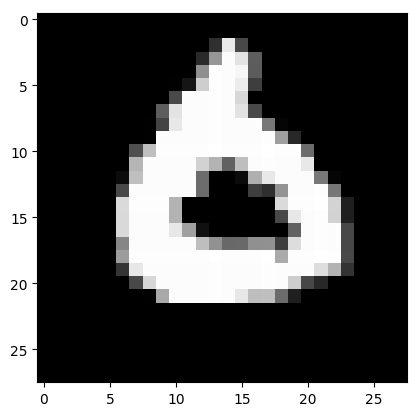

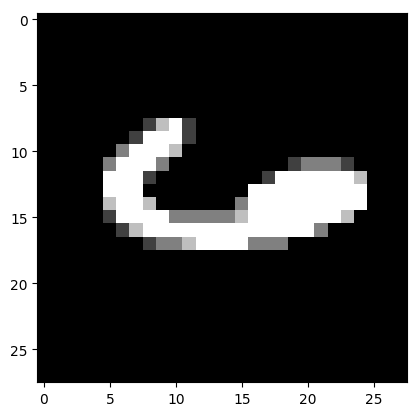

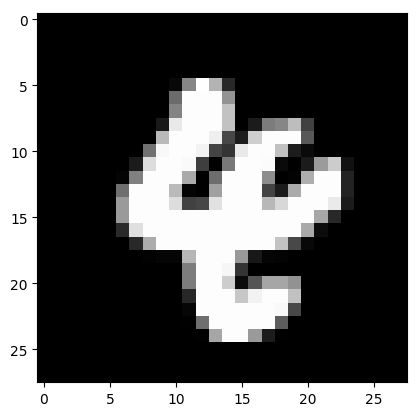

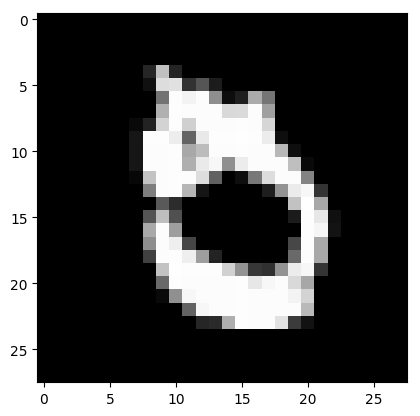

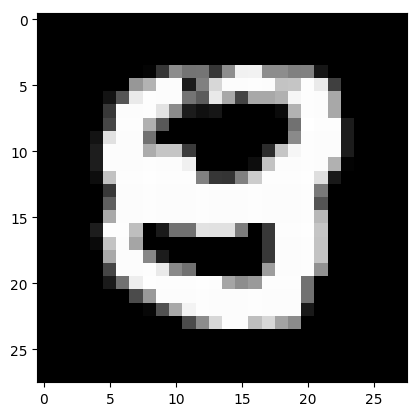

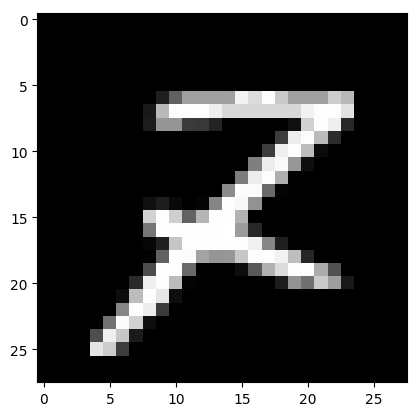

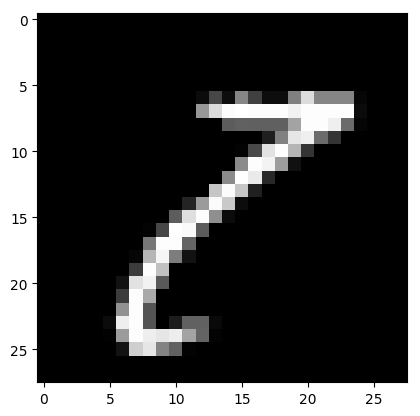

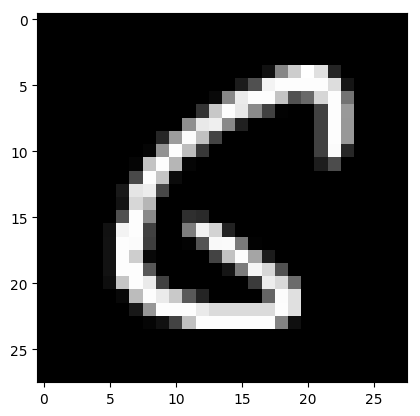

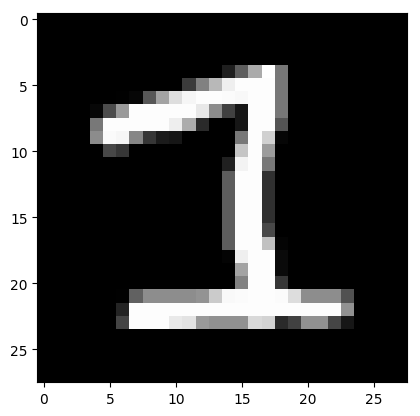

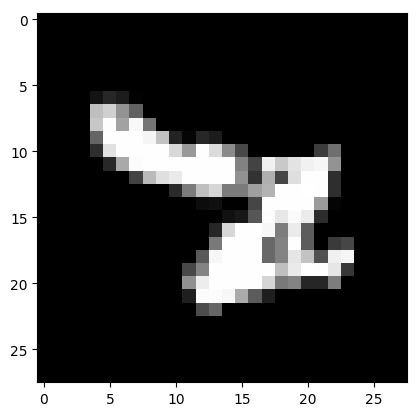

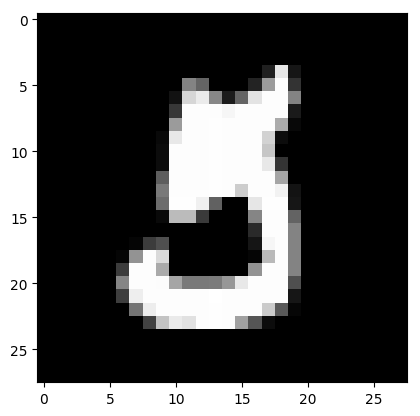

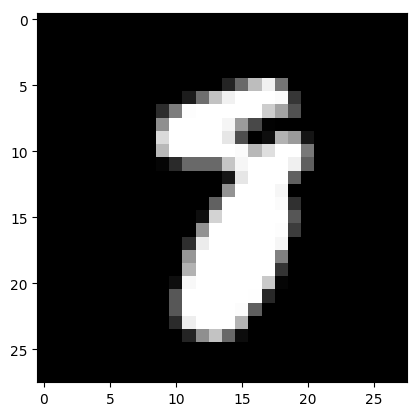

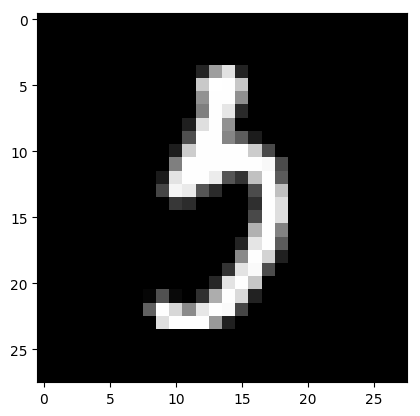

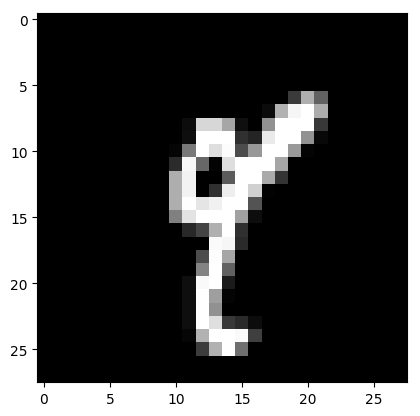

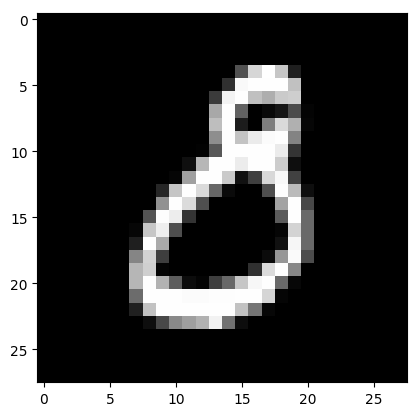

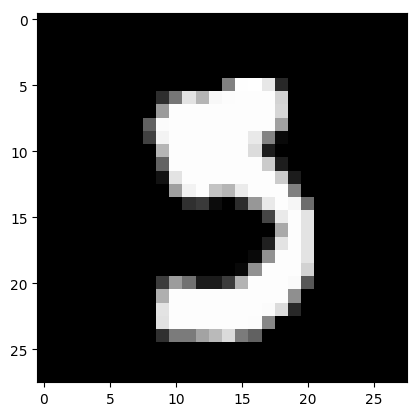

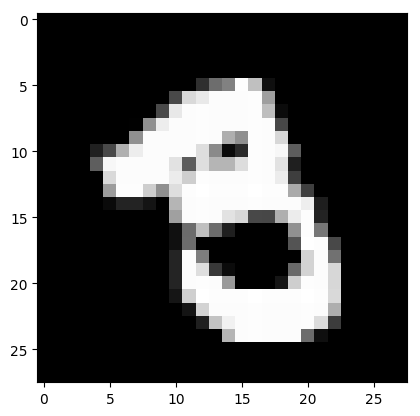

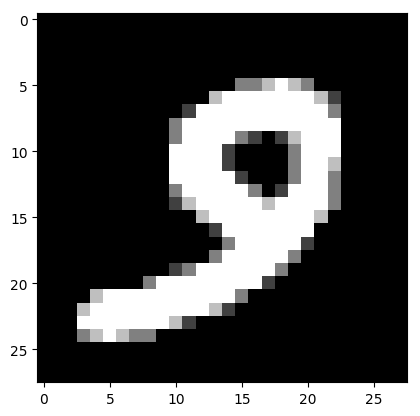

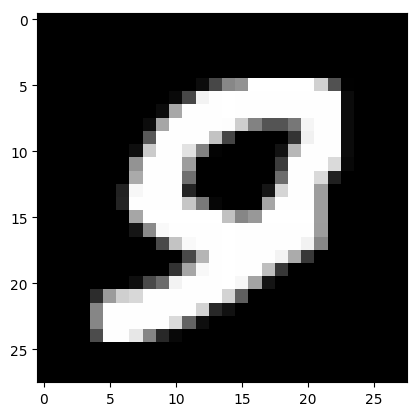

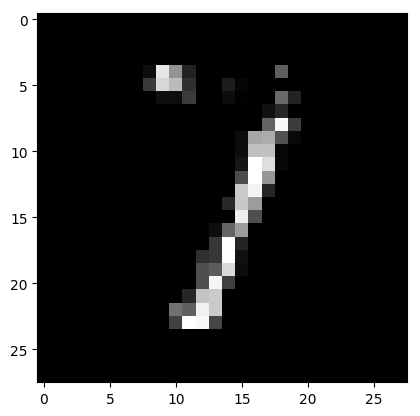

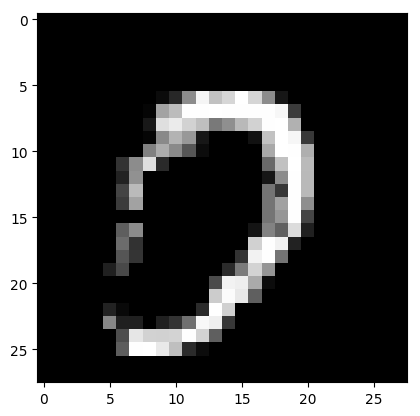

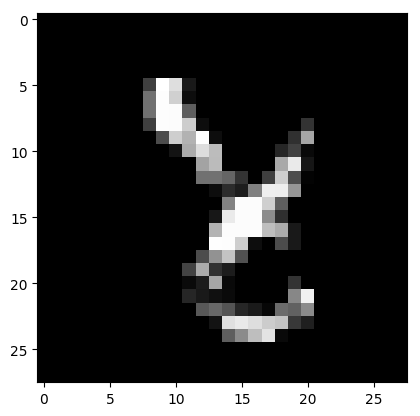

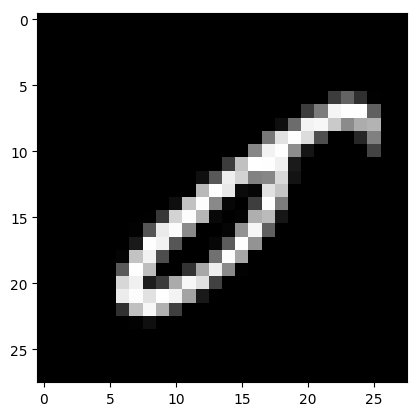

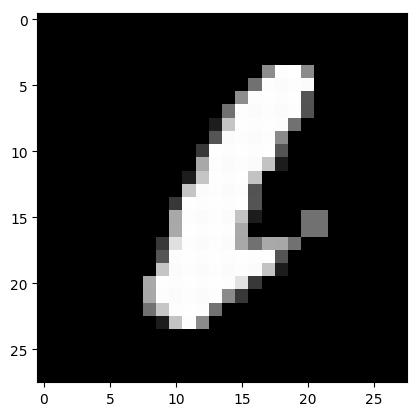

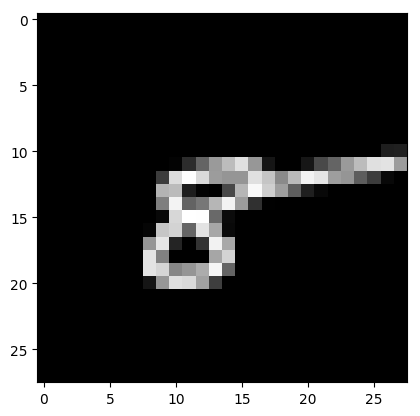

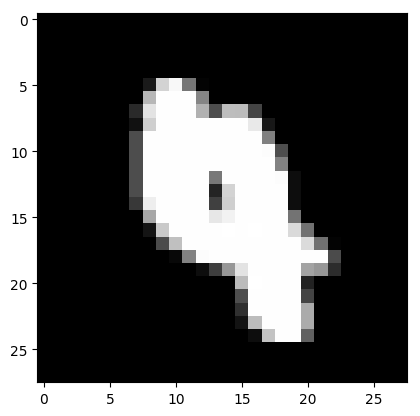

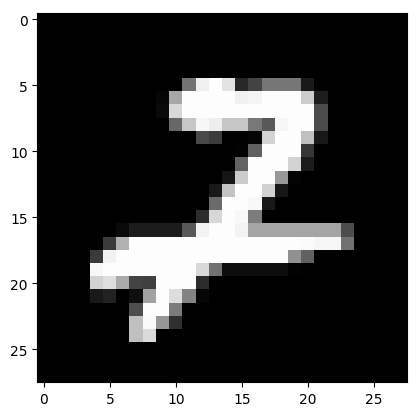

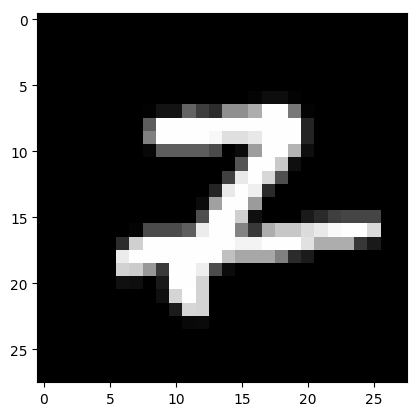

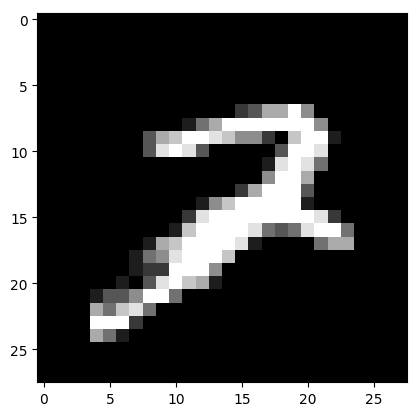

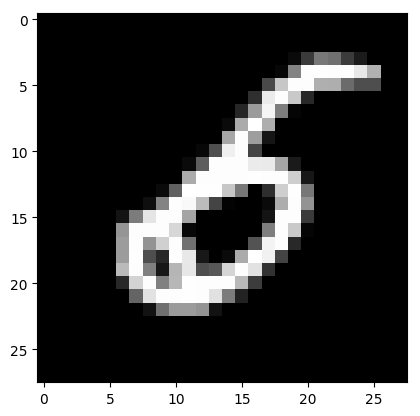

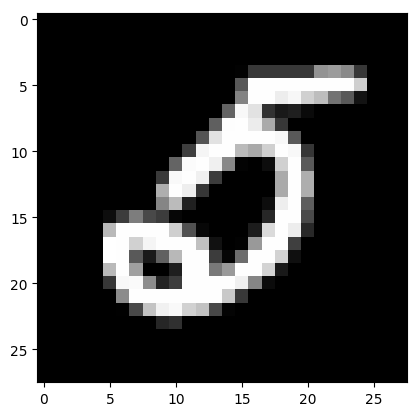

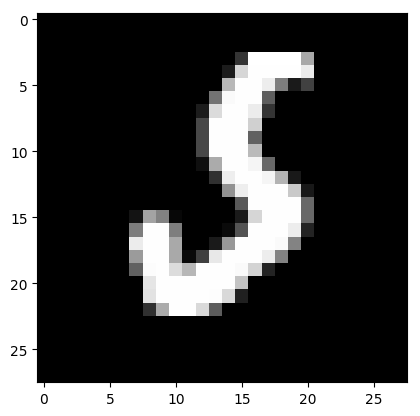

In [107]:
both_incorrect_indices = np.nonzero(both_incorrect)[0]
print(both_incorrect_indices.shape)
for index in both_incorrect_indices:
    plt.imshow(mnist_test_full[index], cmap=plt.get_cmap('gray'))
    plt.show()

In [ ]:
# IDEA -- Combine CNN and GP outputs
# If both outputs agree with highest probability in a class, return that class + prob
# if disagree, default to GP and return probability with +- 2 stddev to the user to judge!

# Question: can we combine results from CNN _and_ GP to improve classification results?

combined_decision = []
both_models_wrong = 0
i = 0
for (gp_probs, gp_vars, cnn_probs, correct) in zip(mu, var, cnn_test_output, correct_classes):
    
    gp_class = np.argmax(gp_probs)
    cnn_class = np.argmax(cnn_probs)
    gp_pred_prob = gp_probs[gp_class]
    cnn_pred_prob = cnn_probs[cnn_class]
     
    if gp_class == cnn_class:
        # we may have to accept the wrong decision here... no clue that it might be wrong except maybe a lower probability
        combined_decision.append([0, gp_class, gp_pred_prob, gp_probs]) # save for quick access
        if gp_class != correct:
            both_models_wrong += 1
    else:
        # disagreement! This is additional information
        # From prior experiments we learn that NN is more likely to be correct [non-adverserial examples]
        # So, if we take the CNN prediction and check if it's the same as the _second_ highest GP prediction
        # try using that?
        
        # Revised:
        #  Take the CNN prediction IF it's probability is within 1 stddev of the corresponding GP class probability
        
        gp_prob_for_cnn_pred = gp_probs[cnn_class]
        gp_stddev_for_cnn_pred = np.sqrt(gp_vars[cnn_class])
        
        print("Disagreement: ", i)
        i += 1
        if cnn_pred_prob < (gp_prob_for_cnn_pred + gp_stddev_for_cnn_pred):
            combined_decision.append([0, cnn_class, cnn_pred_prob, -1]) # tag with GP source, variance column is N/A
            print("Taking CNN prediction: ")
        else:
            combined_decision.append([0, gp_class, gp_pred_prob, gp_probs]) # save for quick access
            print("Taking GP prediction: ")

        print("Correct: ", correct, " \n \tCNN predicts", cnn_class, " with prob ", cnn_pred_prob, '.')
        print("\tGP predicts", gp_class, " with prob ", gp_pred_prob, ' and var ', gp_vars[gp_class])
        print("\tGP's prob for CNN prob: ", gp_prob_for_cnn_pred," with 1 stddev ", gp_prob_for_cnn_pred+ gp_stddev_for_cnn_pred)
        

combined_decision = np.array(decision)

print(np.count_nonzero(combined_decision[:, 1] == correct_classes))
print(both_models_wrong)


In [13]:
# Just for interest, check how an SVM does
# Unfortunately no probabilities so will ignore for now

from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', probability=True)
ys = np.argmax(ys_train_full, axis=1) # no need for 1-hot encoding
clf.fit(xs_train_full, ys) 

pred = clf.predict(xs_test_full)
print(pred)
print("SVM correct classificaitons: ",  np.count_nonzero(pred != correct_classes))

[7 2 1 ..., 4 5 6]


NameError: name 'correct_classes' is not defined